# TriOS Package Test Notebook - Above-Water Radiometry (AWR)

This notebook tests the functionality (in built and new additions) of the TriOS package for processing Above-Water Radiometry data. We'll follow the processing flow from `main.py` to:

1. **Load and inspect** the test data from `./test/data`
2. **Read and clean** the radiometric data (Ed, Lsky, Lt)
3. **Process** the data using different methods
4. **Visualize** intermediate and final outputs
5. **Validate** the processing pipeline


In [1]:
# Setup and Imports
import os
import sys

# Add the trios package to path
sys.path.insert(0, '..')

# Add surface_sky_radiance_ratio module path explicitly
sys.path.insert(0, '/home/soham01123/dev/surface_sky_radiance_ratio')

import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl


# Import trios modules
from trios.utils.utils import plot as up
from trios.utils import utils as u
from trios.process import *
from trios import __package__, __version__
from surface_sky_radiance_ratio import lut

# Set up directories
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, '..', 'test', 'data')
results_dir = os.path.join(current_dir, '..', 'test', 'results')
fig_dir = os.path.join(current_dir, '..', 'test', 'fig')

# Create directories if they don't exist
os.makedirs(results_dir, exist_ok=True)
os.makedirs(fig_dir, exist_ok=True)

print("Imports and setup completed")
print(f"Data directory: {data_dir}")
print(f"Results directory: {results_dir}")
print(f"Figure directory: {fig_dir}")

Imports and setup completed
Data directory: /home/soham01123/dev/trios_linux/notebook/../test/data
Results directory: /home/soham01123/dev/trios_linux/notebook/../test/results
Figure directory: /home/soham01123/dev/trios_linux/notebook/../test/fig


In [2]:
# Explore the test data directory structure
print("=== Test Data Directory Contents ===")
if os.path.exists(data_dir):
    files = os.listdir(data_dir)
    files.sort()
    
    print(f"Total files: {len(files)}")
    print("\nFile listing:")
    for i, file in enumerate(files, 1):
        file_path = os.path.join(data_dir, file)
        if os.path.isfile(file_path):
            size = os.path.getsize(file_path)
            print(f"{i:2d}. {file:<30} ({size:,} bytes)")
    
    # Look for AWR-specific files (following main.py logic)
    print("\n=== AWR File Analysis ===")
    
    # Define test parameters (from README examples)
    idpr = "150"  # ID of the acquisition series
    type_prefix = "aw"  # AWR type prefix
    
    # Find AWR files for the specified IDpr
    pattern = os.path.join(data_dir, f"{type_prefix}*{idpr}*.csv")
    awr_files = glob.glob(pattern)
    
    print(f"Looking for pattern: {type_prefix}*{idpr}*.csv")
    print(f"Found {len(awr_files)} AWR files:")
    
    for file in awr_files:
        filename = os.path.basename(file)
        print(f"  - {filename}")
        
        # Categorize files (Ed, Lsky, Lt)
        if 'Ed' in filename:
            print(f"    → Irradiance data (Ed)")
        elif 'Lsky' in filename:
            print(f"    → Sky radiance data (Lsky)")
        elif 'Lt' in filename:
            print(f"    → Water radiance data (Lt)")
        else:
            print(f"    → Unknown type")
            
else:
    print(f"Data directory not found: {data_dir}")
    print("Please check the path and ensure test data is available.")

=== Test Data Directory Contents ===
Total files: 10

File listing:
 1. Lu0+_Ed_SAM8528_idpr150.csv    (217,935 bytes)
 2. Lu0+_Lu0+_SAM8535_idpr150.csv  (166,395 bytes)
 3. aw_Ed_SAMIP5030_idpr150.csv    (215,260 bytes)
 4. aw_Lsky_SAM81CD_idpr150.csv    (202,502 bytes)
 5. aw_Lt_SAM822C_idpr150.csv      (163,714 bytes)
 6. aw_Lw_idpr150.csv              (8,428 bytes)
 7. metadata.csv                   (814 bytes)
 8. uw_Ed_SAM8528_idpr150.csv      (507,075 bytes)
 9. uw_Edz_SAMIP50CD_idpr150_hobo.csv (372,808 bytes)
10. uw_Luz_SAM8535_idpr150_hobo.csv (269,361 bytes)

=== AWR File Analysis ===
Looking for pattern: aw*150*.csv
Found 4 AWR files:
  - aw_Lw_idpr150.csv
    → Unknown type
  - aw_Lt_SAM822C_idpr150.csv
    → Water radiance data (Lt)
  - aw_Ed_SAMIP5030_idpr150.csv
    → Irradiance data (Ed)
  - aw_Lsky_SAM81CD_idpr150.csv
    → Sky radiance data (Lsky)


In [3]:
# Initialize AWR data processing (following main.py logic)
print("=== AWR Data Initialization ===")

# Test parameters (from README examples)
idpr = "150"
lat = 42.30351823   # Latitude in decimal degrees
lon = 9.462897398   # Longitude in decimal degrees
alt = 0             # Altitude in meters
utc_conv = 0        # UTC conversion hours
file_format = 'csv' # File format
method = 'M99'      # Processing method
name = "_test"      # Name suffix for outputs
vza = 40           # Viewing zenith angle
azi = 135          # Azimuth angle  
ws = 2             # Wind speed
aot = 0.1          # Aerosol optical thickness

print(f"Processing parameters:")
print(f"  IDpr: {idpr}")
print(f"  Location: {lat:.6f}°N, {lon:.6f}°E")
print(f"  Altitude: {alt} m")
print(f"  Method: {method}")
print(f"  Viewing geometry: VZA={vza}°, AZI={azi}°")
print(f"  Atmospheric: WS={ws} m/s, AOT={aot}")

# Find AWR files for this IDpr (following main.py logic)
type_prefix = "aw"  # AWR type from type_list
files = glob.glob(os.path.join(data_dir, f"{type_prefix}*{idpr}*.csv"))

if not files:
    print(f"\nERROR: No AWR files found for IDpr {idpr}")
    print(f"   Pattern searched: {type_prefix}*{idpr}*.csv")
    print(f"   Directory: {data_dir}")
else:
    print(f"\nFound {len(files)} AWR files:")
    for file in files:
        print(f"  - {os.path.basename(file)}")
    
    # Initialize AWR data loader (following main.py logic)
    print(f"\n=== Initializing AWR Data Loader ===")
    try:
        uawr = u.awr_data(idpr, files)
        print(f"AWR data loader initialized successfully")
        print(f"  Ed files: {len(uawr.Edf)}")
        print(f"  Lsky files: {len(uawr.Lskyf)}")
        print(f"  Lt files: {len(uawr.Ltf)}")
        
        # Display file assignments
        print(f"\nFile assignments:")
        if uawr.Edf:
            print(f"  Ed (Irradiance): {os.path.basename(uawr.Edf[0])}")
        if uawr.Lskyf:
            print(f"  Lsky (Sky): {os.path.basename(uawr.Lskyf[0])}")
        if uawr.Ltf:
            print(f"  Lt (Water): {os.path.basename(uawr.Ltf[0])}")
            
    except Exception as e:
        print(f"ERROR initializing AWR data loader: {e}")
        uawr = None

=== AWR Data Initialization ===
Processing parameters:
  IDpr: 150
  Location: 42.303518°N, 9.462897°E
  Altitude: 0 m
  Method: M99
  Viewing geometry: VZA=40°, AZI=135°
  Atmospheric: WS=2 m/s, AOT=0.1

Found 4 AWR files:
  - aw_Lw_idpr150.csv
  - aw_Lt_SAM822C_idpr150.csv
  - aw_Ed_SAMIP5030_idpr150.csv
  - aw_Lsky_SAM81CD_idpr150.csv

=== Initializing AWR Data Loader ===
AWR data loader initialized successfully
  Ed files: 1
  Lsky files: 1
  Lt files: 1

File assignments:
  Ed (Irradiance): aw_Ed_SAMIP5030_idpr150.csv
  Lsky (Sky): aw_Lsky_SAM81CD_idpr150.csv
  Lt (Water): aw_Lt_SAM822C_idpr150.csv


In [4]:
# Read and inspect the raw AWR data
print("=== Reading AWR Data ===")

if uawr is not None:
    try:
        # Read the data using the AWR data reader (following main.py logic)
        df, wl = uawr.reader(lat, lon, alt, utc_conv=utc_conv, file_format=file_format)
        
        print(f"Data reading successful!")
        print(f"  DataFrame shape: {df.shape}")
        print(f"  Wavelength range: {wl.min():.1f} - {wl.max():.1f} nm")
        print(f"  Number of wavelengths: {len(wl)}")
        print(f"  Time range: {df.index.min()} to {df.index.max()}")
        
        # Get date for file naming (following main.py logic)
        date = df.index[0].date().__str__()
        print(f"  Measurement date: {date}")
        
        # Inspect DataFrame structure
        print(f"\n=== DataFrame Structure ===")
        print(f"Index type: {type(df.index)}")
        print(f"Columns type: {type(df.columns)}")
        print(f"Column levels: {df.columns.nlevels}")
        
        if df.columns.nlevels > 1:
            print(f"Multi-level columns detected:")
            print(f"  Level 0 (parameters): {df.columns.get_level_values(0).unique().tolist()}")
            print(f"  Level 1 sample (wavelengths): {df.columns.get_level_values(1).unique()[:10].tolist()}...")
        
        # Display first few rows and columns
        print(f"\n=== Data Preview ===")
        print("First 3 rows, first 5 wavelength columns:")
        print(df.iloc[:3, :15])  # Show first 3 rows, first 15 columns
        
        # Check for any missing data
        print(f"\n=== Data Quality Check ===")
        total_values = df.size
        missing_values = df.isnull().sum().sum()
        print(f"  Total values: {total_values:,}")
        print(f"  Missing values: {missing_values:,} ({missing_values/total_values*100:.2f}%)")
        
        # Check solar zenith angles
        if ('sza', '') in df.columns:
            sza_values = df[('sza', '')]
            print(f"  Solar zenith angles: {sza_values.min():.1f}° - {sza_values.max():.1f}°")
            print(f"  Mean SZA: {sza_values.mean():.1f}°")
            
    except Exception as e:
        print(f"ERROR reading AWR data: {e}")
        print(f"   Exception type: {type(e).__name__}")
        import traceback
        traceback.print_exc()
        df, wl = None, None
else:
    print("Cannot read data - AWR loader not initialized")
    df, wl = None, None

=== Reading AWR Data ===
['/home/soham01123/dev/trios_linux/notebook/../test/data/aw_Ed_SAMIP5030_idpr150.csv']
Warning! Multiple files found but only one expected, trios first file of the list:
['/home/soham01123/dev/trios_linux/notebook/../test/data/aw_Ed_SAMIP5030_idpr150.csv']
['/home/soham01123/dev/trios_linux/notebook/../test/data/aw_Lsky_SAM81CD_idpr150.csv']
Warning! Multiple files found but only one expected, trios first file of the list:
['/home/soham01123/dev/trios_linux/notebook/../test/data/aw_Lsky_SAM81CD_idpr150.csv']
['/home/soham01123/dev/trios_linux/notebook/../test/data/aw_Lt_SAM822C_idpr150.csv']
Warning! Multiple files found but only one expected, trios first file of the list:
['/home/soham01123/dev/trios_linux/notebook/../test/data/aw_Lt_SAM822C_idpr150.csv']
Data reading successful!
  DataFrame shape: (44, 636)
  Wavelength range: 320.0 - 950.0 nm
  Number of wavelengths: 211
  Time range: 2018-05-30 11:48:49 to 2018-05-30 11:50:48
  Measurement date: 2018-05-30


=== Raw Data Visualization ===
Ed: 44 measurements plotted
Ed: 44 measurements plotted
Lsky: 44 measurements plotted
Lt: 44 measurements plotted
Lsky: 44 measurements plotted
Lt: 44 measurements plotted


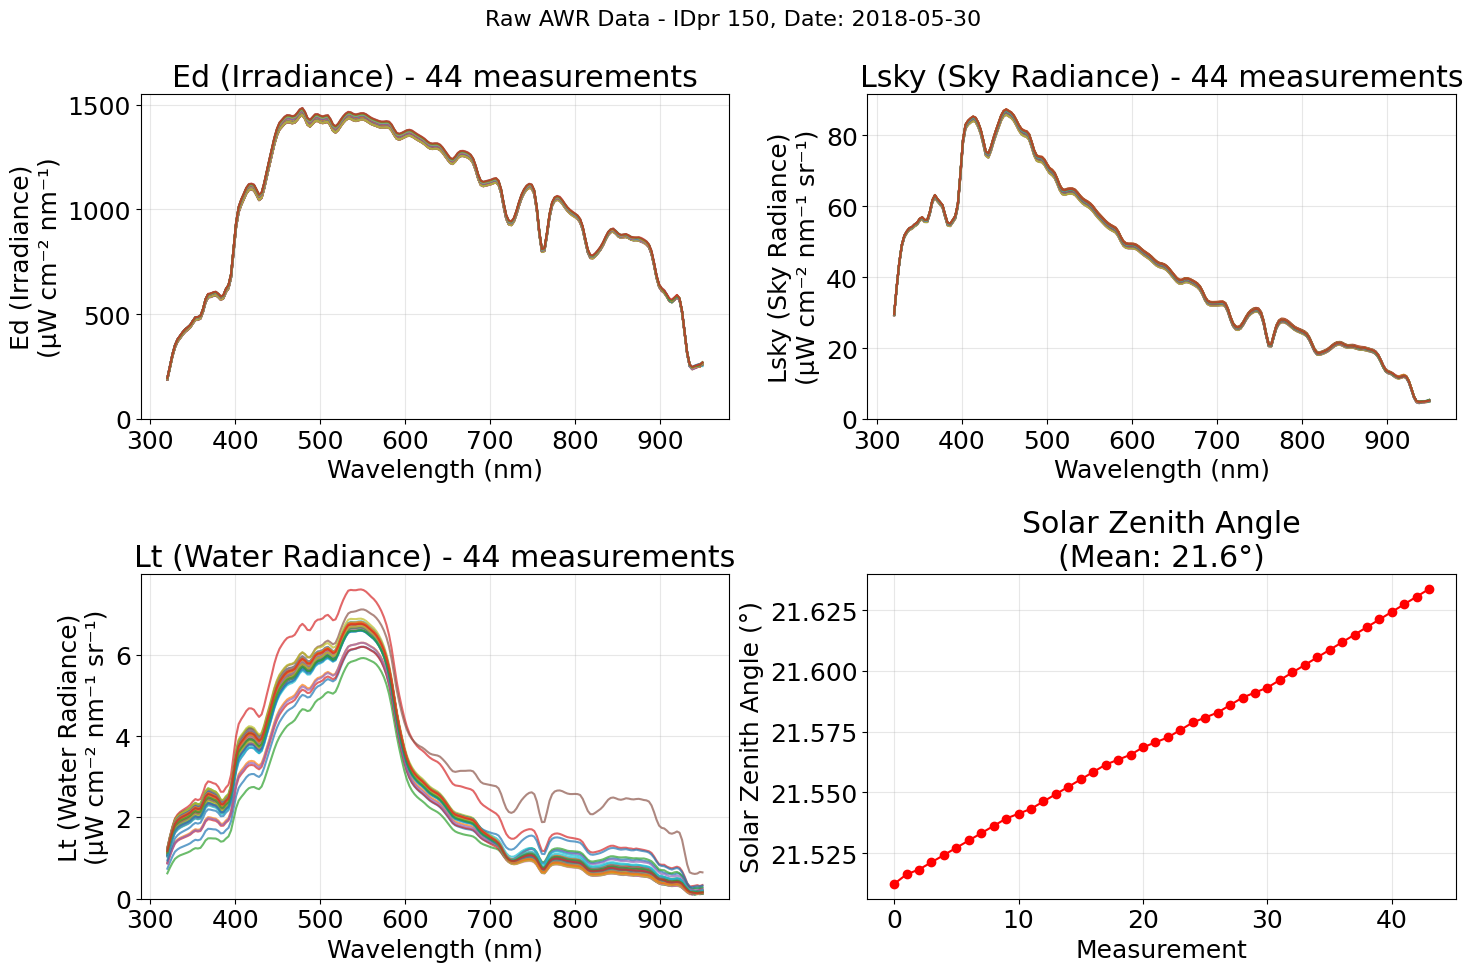


=== Data Statistics ===
Ed:
  Shape: (44, 211)
  Range: 1.87e+02 - 1.48e+03
  Mean: 1.02e+03
Lsky:
  Shape: (44, 211)
  Range: 4.40e+00 - 8.74e+01
  Mean: 4.38e+01
Lt:
  Shape: (44, 211)
  Range: 9.58e-02 - 7.61e+00
  Mean: 2.66e+00


In [5]:
# Visualize the raw spectral data
print("=== Raw Data Visualization ===")

if df is not None and wl is not None:
    try:
        # Create subplots for Ed, Lsky, and Lt
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'Raw AWR Data - IDpr {idpr}, Date: {date}', fontsize=16)
        
        # Extract data for each parameter
        params_to_plot = ['Ed', 'Lsky', 'Lt']
        param_labels = ['Ed (Irradiance)', 'Lsky (Sky Radiance)', 'Lt (Water Radiance)']
        param_units = ['μW cm⁻² nm⁻¹', 'μW cm⁻² nm⁻¹ sr⁻¹', 'μW cm⁻² nm⁻¹ sr⁻¹']
        
        for i, (param, label, unit) in enumerate(zip(params_to_plot, param_labels, param_units)):
            ax = axes[i//2, i%2]
            
            if param in df.columns.get_level_values(0):
                # Get data for this parameter
                param_data = df[param]
                
                # Plot each measurement as a line
                for idx, (timestamp, spectrum) in enumerate(param_data.iterrows()):
                    alpha = 0.7 if len(param_data) > 1 else 1.0
                    ax.plot(wl, spectrum.values, alpha=alpha, linewidth=1.5, 
                           label=f'{timestamp.strftime("%H:%M:%S")}' if idx < 5 else "")
                
                ax.set_xlabel('Wavelength (nm)')
                ax.set_ylabel(f'{label}\n({unit})')
                ax.set_title(f'{label} - {len(param_data)} measurements')
                ax.grid(True, alpha=0.3)
                
                # Add legend only if few measurements
                if len(param_data) <= 5:
                    ax.legend(fontsize=10)
                    
                # Set reasonable y-limits
                ax.set_ylim(bottom=0)
                
                print(f"{param}: {len(param_data)} measurements plotted")
            else:
                ax.text(0.5, 0.5, f'{param} data\nnot found', 
                       ha='center', va='center', transform=ax.transAxes)
                ax.set_title(f'{label} - NOT FOUND')
                print(f"{param}: Not found in data")
        
        # Plot solar zenith angle in the 4th subplot
        ax = axes[1, 1]
        if ('sza', '') in df.columns:
            sza_data = df[('sza', '')]
            timestamps = [t.strftime("%H:%M:%S") for t in sza_data.index]
            ax.plot(range(len(sza_data)), sza_data.values, 'ro-', markersize=6)
            ax.set_xlabel('Measurement')
            ax.set_ylabel('Solar Zenith Angle (°)')
            ax.set_title(f'Solar Zenith Angle\n(Mean: {sza_data.mean():.1f}°)')
            ax.grid(True, alpha=0.3)
            
            # Set x-tick labels to timestamps if not too many
            if len(timestamps) <= 10:
                ax.set_xticks(range(len(timestamps)))
                ax.set_xticklabels(timestamps, rotation=45)
        else:
            ax.text(0.5, 0.5, 'SZA data\nnot found', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Solar Zenith Angle - NOT FOUND')
        
        plt.tight_layout()
        plt.show()
        
        # Print data statistics
        print(f"\n=== Data Statistics ===")
        for param in params_to_plot:
            if param in df.columns.get_level_values(0):
                param_data = df[param]
                print(f"{param}:")
                print(f"  Shape: {param_data.shape}")
                print(f"  Range: {param_data.values.min():.2e} - {param_data.values.max():.2e}")
                print(f"  Mean: {param_data.values.mean():.2e}")
                
    except Exception as e:
        print(f"ERROR creating visualization: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Cannot visualize - data not available")

In [6]:
# Process AWR data using standard M99 method (following main.py logic)
print("=== AWR Data Processing ===")

if df is not None and wl is not None:
    try:
        # Initialize AWR processor (following main.py logic)
        print(f"Initializing AWR processor...")
        awr = awr_process(df, wl, name, idpr)
        print(f"AWR processor initialized")
        
        # Set up output file path (following main.py logic)
        ofile = os.path.join(results_dir, f'Rrs_awr_{date}_idpr{idpr}{name}.csv')
        figfile = os.path.join(fig_dir, f'trios_awr_{date}_idpr{idpr}{name}.png')
        
        print(f"Output file: {ofile}")
        print(f"Figure file: {figfile}")
        
        # Process the data using the call_process method (following main.py logic)
        print(f"\nProcessing with method: {method}")
        print(f"Parameters: VZA={vza}°, AZI={azi}°, WS={ws} m/s, AOT={aot}")
        
        # Suppress verbose output from call_process
        print(f"Running {method} processing...", end=" ")
        
        import io
        import sys
        from contextlib import redirect_stdout
        
        # Redirect stdout to suppress prints
        f = io.StringIO()
        with redirect_stdout(f):
            # Call the main processing function
            Rrs_result = awr.call_process(method, ofile, vza=vza, azi=azi, ws=ws, aot=aot, plot_file=figfile)
        
        print(f"Processing completed successfully!")
        
        # Inspect the results
        if hasattr(awr, 'Rrs') and awr.Rrs is not None:
            print(f"\n=== Processing Results ===")
            print(f"Rrs shape: {awr.Rrs.shape}")
            print(f"Rrs type: {type(awr.Rrs)}")
            
            # Handle pandas DataFrame/Series vs numpy array properly
            if hasattr(awr.Rrs, 'values'):  # pandas DataFrame/Series
                rrs_values = awr.Rrs.values
                if hasattr(awr.Rrs, 'min'):
                    rrs_min = float(awr.Rrs.min().min()) if hasattr(awr.Rrs.min(), 'min') else float(awr.Rrs.min())
                    rrs_max = float(awr.Rrs.max().max()) if hasattr(awr.Rrs.max(), 'max') else float(awr.Rrs.max())
                    rrs_mean = float(awr.Rrs.mean().mean()) if hasattr(awr.Rrs.mean(), 'mean') else float(awr.Rrs.mean())
                else:
                    rrs_min = float(np.min(rrs_values))
                    rrs_max = float(np.max(rrs_values))
                    rrs_mean = float(np.mean(rrs_values))
            else:  # numpy array
                rrs_values = awr.Rrs
                rrs_min = float(np.min(rrs_values))
                rrs_max = float(np.max(rrs_values))
                rrs_mean = float(np.mean(rrs_values))
            
            print(f"Rrs range: {rrs_min:.6f} - {rrs_max:.6f} sr⁻¹")
            print(f"Rrs mean: {rrs_mean:.6f} sr⁻¹")
            
            # Check for negative values
            negative_count = np.sum(rrs_values < 0)
            total_count = rrs_values.size
            print(f"Negative values: {negative_count}/{total_count} ({negative_count/total_count*100:.1f}%)")
            
            # Display first few values
            print(f"\nFirst measurement Rrs values (first 10 wavelengths):")
            if hasattr(awr.Rrs, 'iloc'):
                print(awr.Rrs.iloc[0, :10])
            elif hasattr(awr.Rrs, '__getitem__'):
                if len(awr.Rrs.shape) > 1:
                    print(awr.Rrs[0, :10])
                else:
                    print(awr.Rrs[:10])
            else:
                print("Cannot display sample values")
        else:
            print("No Rrs results found in processor")
            
        # Check if files were created
        print(f"\n=== Output Files ===")
        if os.path.exists(ofile):
            size = os.path.getsize(ofile)
            print(f"Results file created: {os.path.basename(ofile)} ({size:,} bytes)")
        else:
            print(f"Results file not created: {os.path.basename(ofile)}")
            
        if os.path.exists(figfile):
            size = os.path.getsize(figfile)
            print(f"Figure file created: {os.path.basename(figfile)} ({size:,} bytes)")
        else:
            print(f"Figure file not created: {os.path.basename(figfile)}")
            
    except Exception as e:
        print(f"❌ ERROR during AWR processing: {e}")
        print(f"   Exception type: {type(e).__name__}")
        import traceback
        traceback.print_exc()
        awr = None
        Rrs_result = None
else:
    print("❌ Cannot process - data not available")
    awr = None
    Rrs_result = None

=== AWR Data Processing ===
Initializing AWR processor...
AWR processor initialized
Output file: /home/soham01123/dev/trios_linux/notebook/../test/results/Rrs_awr_2018-05-30_idpr150_test.csv
Figure file: /home/soham01123/dev/trios_linux/notebook/../test/fig/trios_awr_2018-05-30_idpr150_test.png

Processing with method: M99
Parameters: VZA=40°, AZI=135°, WS=2 m/s, AOT=0.1
Running M99 processing... AWR processor initialized
Output file: /home/soham01123/dev/trios_linux/notebook/../test/results/Rrs_awr_2018-05-30_idpr150_test.csv
Figure file: /home/soham01123/dev/trios_linux/notebook/../test/fig/trios_awr_2018-05-30_idpr150_test.png

Processing with method: M99
Parameters: VZA=40°, AZI=135°, WS=2 m/s, AOT=0.1
Running M99 processing... Processing completed successfully!

=== Processing Results ===
Rrs shape: (44, 211)
Rrs type: <class 'pandas.core.frame.DataFrame'>
Rrs range: -0.000931 - 0.004222 sr⁻¹
Rrs mean: 0.001256 sr⁻¹
Negative values: 79/9284 (0.9%)

First measurement Rrs values (fi

=== Rrs Results Visualization ===
Rrs array shape for plotting: (44, 211)


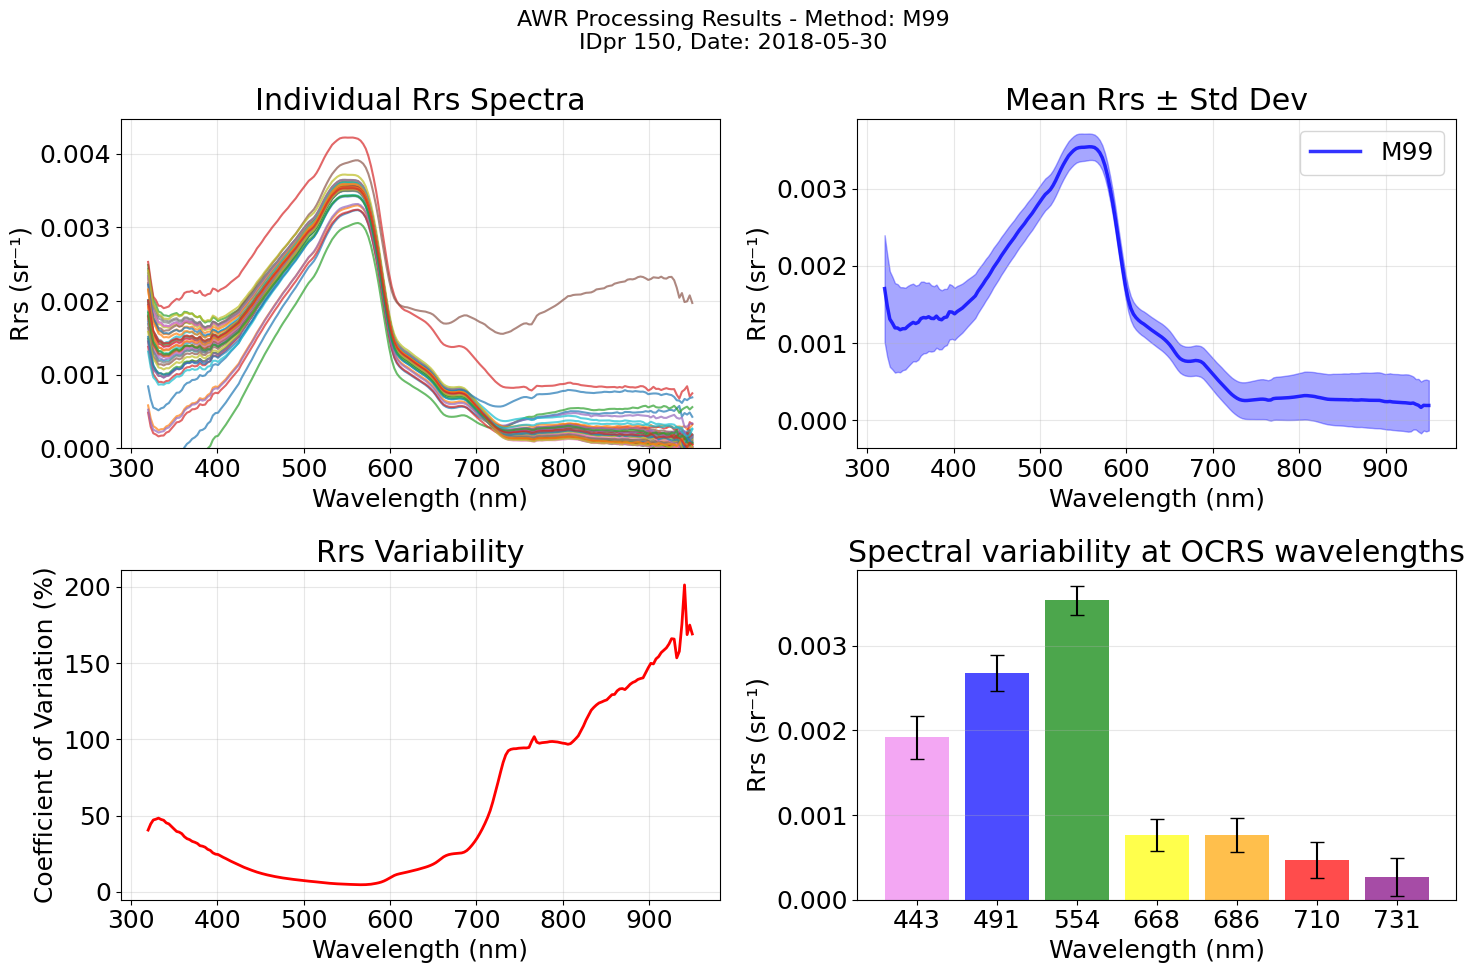


=== Rrs Summary Statistics ===
Shape: (44, 211)
Mean Rrs: 0.001256 sr⁻¹
Std Rrs: 0.001100 sr⁻¹
Min Rrs: -0.000931 sr⁻¹
Max Rrs: 0.004222 sr⁻¹

Key wavelength values:
  443 nm: 0.001917 ± 0.000260 sr⁻¹
  491 nm: 0.002682 ± 0.000215 sr⁻¹
  554 nm: 0.003537 ± 0.000174 sr⁻¹
  668 nm: 0.000767 ± 0.000188 sr⁻¹
  686 nm: 0.000761 ± 0.000199 sr⁻¹
  710 nm: 0.000473 ± 0.000213 sr⁻¹
  731 nm: 0.000268 ± 0.000228 sr⁻¹


In [7]:
# Visualize the processed Rrs results
print("=== Rrs Results Visualization ===")

if awr is not None and hasattr(awr, 'Rrs') and awr.Rrs is not None:
    try:
        # Create figure for Rrs results
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle(f'AWR Processing Results - Method: {method}\nIDpr {idpr}, Date: {date}', fontsize=16)
        
        # Get Rrs data and convert to proper format
        Rrs_data = awr.Rrs
        
        # Convert to numpy array if needed for consistent handling
        if hasattr(Rrs_data, 'values'):
            rrs_array = Rrs_data.values
            if len(rrs_array.shape) == 1:
                rrs_array = rrs_array.reshape(1, -1)  # Make it 2D if 1D
        else:
            rrs_array = np.array(Rrs_data)
            if len(rrs_array.shape) == 1:
                rrs_array = rrs_array.reshape(1, -1)
        
        print(f"Rrs array shape for plotting: {rrs_array.shape}")
        
        # Plot 1: All Rrs spectra
        ax1 = axes[0, 0]
        for i in range(rrs_array.shape[0]):
            alpha = 0.7 if rrs_array.shape[0] > 1 else 1.0
            timestamp_label = f'Measurement {i+1}'
            if hasattr(Rrs_data, 'index') and len(Rrs_data.index) > i:
                if hasattr(Rrs_data.index[i], 'strftime'):
                    timestamp_label = Rrs_data.index[i].strftime("%H:%M:%S")
            
            ax1.plot(wl, rrs_array[i, :], alpha=alpha, linewidth=1.5,
                    label=timestamp_label if i < 5 else "")
        
        ax1.set_xlabel('Wavelength (nm)')
        ax1.set_ylabel('Rrs (sr⁻¹)')
        ax1.set_title('Individual Rrs Spectra')
        ax1.grid(True, alpha=0.3)
        ax1.set_ylim(bottom=0)
        if rrs_array.shape[0] <= 5:
            ax1.legend(fontsize=10)
        
        # Plot 2: Mean Rrs with std
        ax2 = axes[0, 1]
        mean_Rrs = np.mean(rrs_array, axis=0)
        std_Rrs = np.std(rrs_array, axis=0)
        
        up.add_curve(ax2, wl, mean_Rrs, std_Rrs, label=f'{method}', c='blue')
        ax2.set_xlabel('Wavelength (nm)')
        ax2.set_ylabel('Rrs (sr⁻¹)')
        ax2.set_title('Mean Rrs ± Std Dev')
        ax2.grid(True, alpha=0.3)
        ax2.legend()
        
        # Plot 3: Rrs statistics by wavelength
        ax3 = axes[1, 0]
        # Avoid division by zero
        cv = np.where(mean_Rrs != 0, (std_Rrs / mean_Rrs) * 100, 0)
        
        ax3.plot(wl, cv, 'r-', linewidth=2)
        ax3.set_xlabel('Wavelength (nm)')
        ax3.set_ylabel('Coefficient of Variation (%)')
        ax3.set_title('Rrs Variability')
        ax3.grid(True, alpha=0.3)
        
        # Plot 4: Key wavelength values
        ax4 = axes[1, 1]
        key_wavelengths = [443, 490, 555, 667, 685, 710, 730]  # Common ocean color wavelengths
        key_indices = [np.argmin(np.abs(wl - wl_target)) for wl_target in key_wavelengths]
        key_wl_actual = [wl[idx] for idx in key_indices]
        
        key_values = [np.mean(rrs_array[:, idx]) for idx in key_indices]
        key_errors = [np.std(rrs_array[:, idx]) for idx in key_indices]
        
        x_pos = np.arange(len(key_wavelengths))
        ax4.bar(x_pos, key_values, yerr=key_errors, capsize=5, alpha=0.7, 
               color=['violet','blue', 'green', 'yellow', 'orange','red', 'purple'])
        ax4.set_xlabel('Wavelength (nm)')
        ax4.set_ylabel('Rrs (sr⁻¹)')
        ax4.set_title('Spectral variability at OCRS wavelengths')
        ax4.set_xticks(x_pos)
        ax4.set_xticklabels([f'{wl:.0f}' for wl in key_wl_actual])
        ax4.grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary statistics
        print(f"\n=== Rrs Summary Statistics ===")
        print(f"Shape: {rrs_array.shape}")
        print(f"Mean Rrs: {np.mean(rrs_array):.6f} sr⁻¹")
        print(f"Std Rrs: {np.std(rrs_array):.6f} sr⁻¹")
        print(f"Min Rrs: {np.min(rrs_array):.6f} sr⁻¹")
        print(f"Max Rrs: {np.max(rrs_array):.6f} sr⁻¹")
        
        print(f"\nKey wavelength values:")
        for wl_target, wl_actual, value, error in zip(key_wavelengths, key_wl_actual, key_values, key_errors):
            print(f"  {wl_actual:.0f} nm: {value:.6f} ± {error:.6f} sr⁻¹")
            
    except Exception as e:
        print(f"❌ ERROR creating Rrs visualization: {e}")
        import traceback
        traceback.print_exc()
else:
    print("❌ Cannot visualize Rrs - processing results not available")

## Adding new methods to calculate spectrally dependent rho (Rss)

In [8]:
# UV+NIR Spline Method
def get_rho_uv_nir_spline(wl, Lt, Lsky, Ed):
    """
    UV+NIR spline interpolation for spectral rho estimation.
    Following R code logic: Rrs = sea.smooth - (rho_spectral * sky.smooth)
    """
    import numpy as np
    from scipy.interpolate import CubicSpline
    
    Lt_array = Lt.values if hasattr(Lt, 'values') else np.array(Lt)
    Lsky_array = Lsky.values if hasattr(Lsky, 'values') else np.array(Lsky)
    Ed_array = Ed.values if hasattr(Ed, 'values') else np.array(Ed)
    wl_array = np.array(wl)
    
    if len(Lt_array.shape) == 1:
        Lt_array = Lt_array.reshape(1, -1)
        Lsky_array = Lsky_array.reshape(1, -1)
        Ed_array = Ed_array.reshape(1, -1)
    
    sea_smooth = Lt_array / Ed_array
    sky_smooth = Lsky_array / Ed_array
    
    uv_mask = (wl_array >= 350) & (wl_array <= 380)
    nir_mask = (wl_array >= 890) & (wl_array <= 900)
    uv_indices = np.where(uv_mask)[0]
    nir_indices = np.where(nir_mask)[0]
    
    if len(uv_indices) == 0 or len(nir_indices) == 0:
        return None, None
    
    rho_spectral = np.zeros_like(Lt_array)
    
    for i in range(Lt_array.shape[0]):
        sea_uv = np.mean(sea_smooth[i, uv_indices])
        sky_uv = np.mean(sky_smooth[i, uv_indices])
        sea_nir = np.mean(sea_smooth[i, nir_indices])
        sky_nir = np.mean(sky_smooth[i, nir_indices])
        
        if sky_uv == 0 or sky_nir == 0:
            return None, None
        
        rho_uv = sea_uv / sky_uv
        rho_nir = sea_nir / sky_nir
        
        uv_wl = np.mean(wl_array[uv_indices])
        nir_wl = np.mean(wl_array[nir_indices])
        anchor_wl = np.array([uv_wl, nir_wl])
        anchor_rho = np.array([rho_uv, rho_nir])
        
        try:
            spline_func = CubicSpline(anchor_wl, anchor_rho, bc_type='natural')
            rho_spectral[i, :] = spline_func(wl_array)
        except:
            from scipy.interpolate import interp1d
            interp_func = interp1d(anchor_wl, anchor_rho, kind='linear', 
                                 fill_value='extrapolate', bounds_error=False)
            rho_spectral[i, :] = interp_func(wl_array)
    
    Rrs = sea_smooth - (rho_spectral * sky_smooth)
    return Rrs, rho_spectral

print("UV+NIR method defined")

# Kutser Method
def get_rho_kutser(wl, Lt, Lsky, Ed):
    """
    Kutser et al. 2013 method for removal of sky glint.
    Non-linear regression on UV and NIR spectral regions.
    """
    import numpy as np
    from scipy.optimize import curve_fit
    
    Lt_array = Lt.values if hasattr(Lt, 'values') else np.array(Lt)
    Lsky_array = Lsky.values if hasattr(Lsky, 'values') else np.array(Lsky)
    Ed_array = Ed.values if hasattr(Ed, 'values') else np.array(Ed)
    wl_array = np.array(wl)
    
    if len(Lt_array.shape) == 1:
        Lt_array = Lt_array.reshape(1, -1)
        Lsky_array = Lsky_array.reshape(1, -1)
        Ed_array = Ed_array.reshape(1, -1)
    
    sea_smooth = Lt_array / Ed_array
    
    uv_mask = (wl_array >= 350) & (wl_array <= 380)
    nir_mask = (wl_array >= 890) & (wl_array <= 900)
    uv_indices = np.where(uv_mask)[0]
    nir_indices = np.where(nir_mask)[0]
    
    if len(uv_indices) == 0 or len(nir_indices) == 0:
        return None, None
    
    glint_estimate = np.zeros_like(Lt_array)
    
    def power_law(x, b, z):
        return b * (x ** z)
    
    for i in range(Lt_array.shape[0]):
        uv_data = sea_smooth[i, uv_indices]
        nir_data = sea_smooth[i, nir_indices]
        uv_wl = wl_array[uv_indices]
        nir_wl = wl_array[nir_indices]
        
        combined_data = np.concatenate([uv_data, nir_data])
        combined_wl = np.concatenate([uv_wl, nir_wl])
        
        try:
            popt, _ = curve_fit(power_law, combined_wl, combined_data, 
                              p0=[1.0, -1.0], maxfev=1000)
            b, z = popt
            glint_estimate[i, :] = power_law(wl_array, b, z)
        except:
            mean_offset = np.mean(combined_data)
            glint_estimate[i, :] = mean_offset
    
    Rrs = sea_smooth - glint_estimate
    return Rrs, glint_estimate

print("Kutser method defined")

# Jiang et al. 2020 Method
def get_rho_jiang(wl, Lt, Lsky, Ed, use_mobley_rho=True):
    """
    Jiang et al. 2020 method for spectral shape correction.
    Uses polynomial correction based on spectral indices.
    
    Parameters:
    -----------
    use_mobley_rho : bool
        If True, use M99 rho values as baseline (correct approach)
        If False, use simple NIR ratio (fallback option)
    """
    import numpy as np
    
    Lt_array = Lt.values if hasattr(Lt, 'values') else np.array(Lt)
    Lsky_array = Lsky.values if hasattr(Lsky, 'values') else np.array(Lsky)
    Ed_array = Ed.values if hasattr(Ed, 'values') else np.array(Ed)
    wl_array = np.array(wl)
    
    if len(Lt_array.shape) == 1:
        Lt_array = Lt_array.reshape(1, -1)
        Lsky_array = Lsky_array.reshape(1, -1)
        Ed_array = Ed_array.reshape(1, -1)
    
    Rrs_initial = np.zeros_like(Lt_array)
    delta_correction = np.zeros(Lt_array.shape[0])
    
    if use_mobley_rho:
        # Use M99 rho values as baseline (correct Jiang approach)
        try:
            from trios.process import awr_process
            
            # Create temporary awr_process object to get M99 rho
            # We need to create a minimal DataFrame for this
            import pandas as pd
            temp_df = pd.DataFrame()
            temp_df['Lt'] = [Lt_array[0, :]]  # Use first measurement as reference
            temp_df['Lsky'] = [Lsky_array[0, :]]
            temp_df['Ed'] = [Ed_array[0, :]]
            temp_df['sza'] = [45.0]  # Default SZA value
            
            temp_awr = awr_process(temp_df, wl_array, "_temp", "temp")
            
            # Get M99 rho value (scalar)
            rho_M99 = temp_awr.get_rho_mobley([45.0], [40], [135], [2], method='M99')
            
            # Apply M99 rho to all measurements
            for i in range(Lt_array.shape[0]):
                Rrs_initial[i, :] = (Lt_array[i, :] - rho_M99 * Lsky_array[i, :]) / Ed_array[i, :]
                
        except Exception as e:
            print(f"Warning: M99 rho calculation failed ({e}), falling back to NIR ratio")
            use_mobley_rho = False
    
    if not use_mobley_rho:
        # Fallback: Use simple NIR-based rho (original implementation)
        nir_mask = (wl_array >= 890) & (wl_array <= 900)
        nir_indices = np.where(nir_mask)[0]
        
        if len(nir_indices) == 0:
            return None, None
        
        for i in range(Lt_array.shape[0]):
            # Simple NIR-based rho for initial Rrs
            Lt_nir = np.mean(Lt_array[i, nir_indices])
            Lsky_nir = np.mean(Lsky_array[i, nir_indices])
            
            if Lsky_nir == 0:
                return None, None
            
            rho_nir = Lt_nir / Lsky_nir
            Rrs_initial[i, :] = (Lt_array[i, :] - rho_nir * Lsky_array[i, :]) / Ed_array[i, :]
    
    # Apply Jiang correction to the baseline Rrs
    for i in range(Lt_array.shape[0]):
        # Find required wavelengths for Jiang method
        idx_780 = np.argmin(np.abs(wl_array - 780))
        idx_810 = np.argmin(np.abs(wl_array - 810))
        idx_840 = np.argmin(np.abs(wl_array - 840))
        
        # Wavelength range for median calculation
        range_750_780 = (wl_array >= 750) & (wl_array <= 780)
        range_indices = np.where(range_750_780)[0]
        
        if len(range_indices) == 0:
            delta_correction[i] = 0
            continue
        
        # Calculate RHW index
        Rrs_780 = Rrs_initial[i, idx_780]
        Rrs_810 = Rrs_initial[i, idx_810]
        Rrs_840 = Rrs_initial[i, idx_840]
        
        RHW = Rrs_810 - Rrs_780 - (Rrs_840 - Rrs_780) * (810 - 780) / (840 - 780)
        
        # Polynomial estimation
        est_md = 18267.884 * (RHW**3) - 129.158 * (RHW**2) + 3.072 * RHW
        
        # Calculate delta correction
        median_750_780 = np.median(Rrs_initial[i, range_indices])
        delta_correction[i] = median_750_780 - est_md
    
    # Apply correction to all wavelengths
    Rrs_corrected = np.zeros_like(Lt_array)
    for i in range(Lt_array.shape[0]):
        Rrs_corrected[i, :] = Rrs_initial[i, :] - delta_correction[i]
    
    return Rrs_corrected, delta_correction

print("Jiang et al. 2020 method defined")

UV+NIR method defined
Kutser method defined
Jiang et al. 2020 method defined


[0.02514379 0.02440997 0.02358825 0.02311463 0.02279958 0.02257289
 0.02220238]


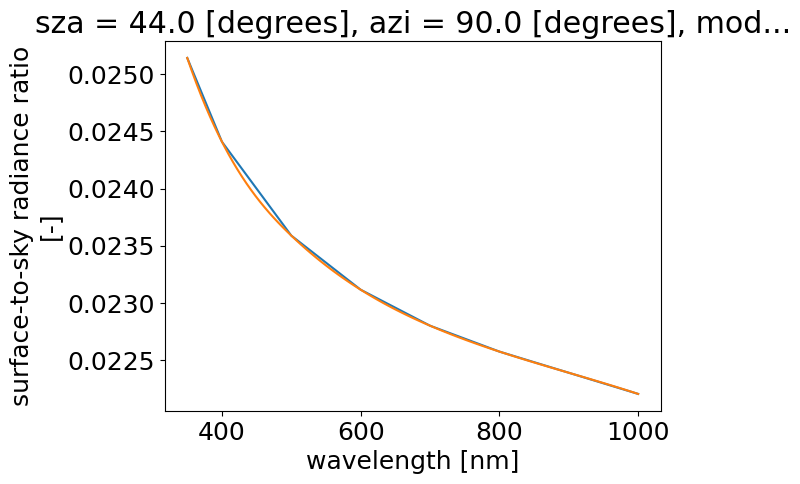

In [9]:
# Adding Harmel (2023) given Rss (rho in other literature) values using a LUT table class

ssrr = lut()
ssrr.load()
ssrr.Rss_lut

# Display the spectral values for Rss for a given sun-sensor geometry
vza=40
azi=90
sza=44
model='MACL_rh70'
aot_ref=0
wind=2
Rss = ssrr.Rss_lut.Rss.sel(model=model).sel(vza=40,azi=90,sza=44,method='nearest').interp(wind=wind).interp(aot_ref=aot_ref)
print(Rss.values)
Rss.plot()

wl_demo=np.linspace(350,1000,100)
Rss.interp(wl=wl_demo,method='cubic').plot()


In [10]:
# Harmel (2023) LUT Functions
def get_rho_harmel2023(sza, vza, azi, ws, aot_ref, model, wl_target, lut_object=None):
    """
    Get rho values from Harmel (2023) LUT and interpolate to target wavelengths.
    
    Parameters:
    -----------
    sza, vza, azi : float
        Sun-sensor geometry (degrees)
    ws : float
        Wind speed (m/s)
    aot_ref : float
        Aerosol optical thickness
    model : str
        Atmospheric model for LUT
    wl_target : array-like
        Target wavelengths for interpolation (nm)
    lut_object : object, optional
        LUT object (if None, uses global ssrr)
        
    Returns:
    --------
    rho_interp : numpy.ndarray
        Interpolated rho values for target wavelengths
    """
    import numpy as np
    
    # Get LUT object
    if lut_object is None:
        if 'ssrr' not in globals():
            return None
        lut_object = ssrr
    
    try:
        # Following the pattern from cell 11: select model, geometry, then interpolate
        Rss_model = lut_object.Rss_lut.Rss.sel(model=model)
        Rss_geom = Rss_model.sel(vza=vza, azi=azi, sza=sza, method='nearest')
        Rss_params = Rss_geom.interp(wind=ws).interp(aot_ref=aot_ref)
        rho_interp = Rss_params.interp(wl=wl_target, method='cubic')
        
        # Convert to numpy array
        if hasattr(rho_interp, 'values'):
            return rho_interp.values
        else:
            return np.array(rho_interp)
        
    except Exception as e:
        print(f"Error in Harmel 2023 rho interpolation: {e}")
        return None

def get_rrs_harmel2023_final(wl, Lt, Lsky, Ed, sza, vza, azi, ws, aot_ref, model='MACL_rh70', lut_object=None):
    """
    Calculate Rrs using Harmel (2023) LUT with proper wavelength alignment.
    
    Parameters:
    -----------
    wl : array-like
        Target wavelength array (nm)
    Lt, Lsky, Ed : DataFrame or array-like
        Radiance/irradiance measurements with wavelength columns
    sza, vza, azi : float
        Sun-sensor geometry (degrees)
    ws : float
        Wind speed (m/s)
    aot_ref : float
        Aerosol optical thickness
    model : str
        Atmospheric model for LUT
        
    Returns:
    --------
    Rrs : numpy.ndarray
        Remote sensing reflectance
    rho_spectral : numpy.ndarray
        Spectral rho values used
    actual_wl : numpy.ndarray
        Actual wavelengths used in calculation
    """
    import numpy as np
    
    # Get LUT object
    if lut_object is None:
        if 'ssrr' not in globals():
            return None, None, None
        lut_object = ssrr
    
    try:
        # Extract wavelength columns from data
        if hasattr(Lt, 'columns'):
            data_wl = np.array([col for col in Lt.columns if isinstance(col, (int, float))])
            data_wl = np.sort(data_wl)
        else:
            data_wl = np.array(wl)
        
        # Find overlapping wavelengths within 5nm tolerance
        wl_target = np.array(wl)
        available_wl = []
        available_indices = []
        
        for i, target_wl in enumerate(wl_target):
            closest_idx = np.argmin(np.abs(data_wl - target_wl))
            closest_wl = data_wl[closest_idx]
            if abs(closest_wl - target_wl) <= 5:
                available_wl.append(closest_wl)
                available_indices.append(i)
        
        if len(available_wl) == 0:
            return None, None, None
        
        available_wl = np.array(available_wl)
        actual_wl = wl_target[available_indices]
        
        # Get rho values for the actual wavelengths
        rho_spectral = get_rho_harmel2023(sza, vza, azi, ws, aot_ref, model, actual_wl, lut_object)
        
        if rho_spectral is None:
            return None, None, None
        
        # Extract measurement data for available wavelengths
        if hasattr(Lt, 'columns'):
            Lt_subset = Lt[available_wl].values
            Lsky_subset = Lsky[available_wl].values
            Ed_subset = Ed[available_wl].values
        else:
            Lt_subset = np.array(Lt)[:, available_indices] if len(Lt.shape) > 1 else np.array(Lt)[available_indices]
            Lsky_subset = np.array(Lsky)[:, available_indices] if len(Lsky.shape) > 1 else np.array(Lsky)[available_indices]
            Ed_subset = np.array(Ed)[:, available_indices] if len(Ed.shape) > 1 else np.array(Ed)[available_indices]
        
        # Ensure 2D arrays
        if len(Lt_subset.shape) == 1:
            Lt_subset = Lt_subset.reshape(1, -1)
            Lsky_subset = Lsky_subset.reshape(1, -1)
            Ed_subset = Ed_subset.reshape(1, -1)
        
        # Broadcast rho to match measurement array shape
        if len(rho_spectral.shape) == 1:
            rho_broadcast = np.tile(rho_spectral, (Lt_subset.shape[0], 1))
        else:
            rho_broadcast = rho_spectral
        
        # Calculate Rrs: Rrs = (Lt - rho*Lsky) / Ed
        Rrs = (Lt_subset - rho_broadcast * Lsky_subset) / Ed_subset
        
        return Rrs, rho_broadcast, actual_wl
        
    except Exception as e:
        print(f"Error in Harmel 2023 calculation: {e}")
        return None, None, None

print("✓ Harmel (2023) LUT functions defined")

✓ Harmel (2023) LUT functions defined


=== Testing Harmel (2023) Method ===
✓ Harmel (2023) calculation successful!
  Wavelengths used: 211 (320-950 nm)
  Rrs range: nan - nan sr⁻¹
  Negative values: 7.6%


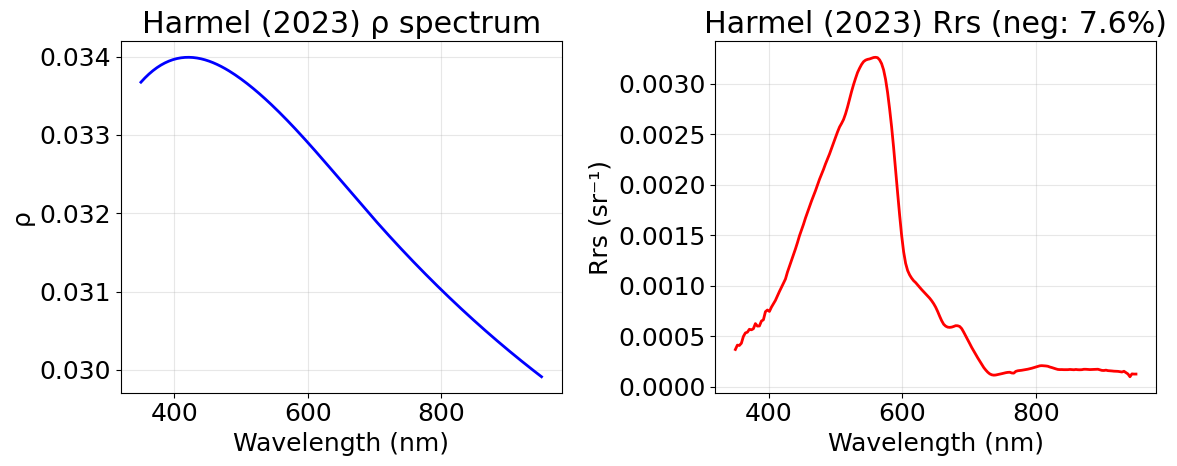

In [11]:
# Test Harmel (2023) Method
if df is not None and wl is not None and 'ssrr' in globals():
    print("=== Testing Harmel (2023) Method ===")
    
    # Test parameters
    test_sza = 45
    test_vza = 40  
    test_azi = 135
    test_ws = 2
    test_aot = 0.1
    test_model = 'MACL_rh70'
    
    # Get data from AWR measurements
    Lt_data = df['Lt']
    Lsky_data = df['Lsky']
    Ed_data = df['Ed']
    
    try:
        # Calculate Rrs using Harmel (2023) method
        rrs_harmel, rho_spectral, actual_wl = get_rrs_harmel2023_final(
            wl, Lt_data, Lsky_data, Ed_data, test_sza, test_vza, test_azi, test_ws, test_aot, test_model)
        
        if rrs_harmel is not None:
            neg_pct = (np.sum(rrs_harmel < 0) / rrs_harmel.size) * 100
            print(f"✓ Harmel (2023) calculation successful!")
            print(f"  Wavelengths used: {len(actual_wl)} ({actual_wl.min():.0f}-{actual_wl.max():.0f} nm)")
            print(f"  Rrs range: {rrs_harmel.min():.6f} - {rrs_harmel.max():.6f} sr⁻¹")
            print(f"  Negative values: {neg_pct:.1f}%")
            
            # Simple visualization
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
            
            # Rho spectrum
            ax1.plot(actual_wl, rho_spectral[0], 'b-', linewidth=2)
            ax1.set_xlabel('Wavelength (nm)')
            ax1.set_ylabel('ρ')
            ax1.set_title('Harmel (2023) ρ spectrum')
            ax1.grid(True, alpha=0.3)
            
            # Rrs spectrum
            mean_rrs = np.mean(rrs_harmel, axis=0)
            ax2.plot(actual_wl, mean_rrs, 'r-', linewidth=2)
            ax2.set_xlabel('Wavelength (nm)')
            ax2.set_ylabel('Rrs (sr⁻¹)')
            ax2.set_title(f'Harmel (2023) Rrs (neg: {neg_pct:.1f}%)')
            ax2.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()
            
        else:
            print("❌ Harmel (2023) calculation failed")
            
    except Exception as e:
        print(f"❌ Error in Harmel method: {e}")
    
else:
    print("❌ Cannot test Harmel method - missing data or LUT object")

=== Jiang Method Baseline Comparison ===
Testing Jiang with M99 baseline...
✓ Jiang (M99 baseline): 2.1% negative, δ=0.000150
Testing Jiang with NIR ratio baseline...
✓ Jiang (NIR baseline): 5.7% negative, δ=-0.000163

=== Baseline Comparison Summary ===
M99 baseline:  2.1% negative, δ=0.000150
NIR baseline:  5.7% negative, δ=-0.000163
Delta difference: 0.000313
✓ Jiang (M99 baseline): 2.1% negative, δ=0.000150
Testing Jiang with NIR ratio baseline...
✓ Jiang (NIR baseline): 5.7% negative, δ=-0.000163

=== Baseline Comparison Summary ===
M99 baseline:  2.1% negative, δ=0.000150
NIR baseline:  5.7% negative, δ=-0.000163
Delta difference: 0.000313


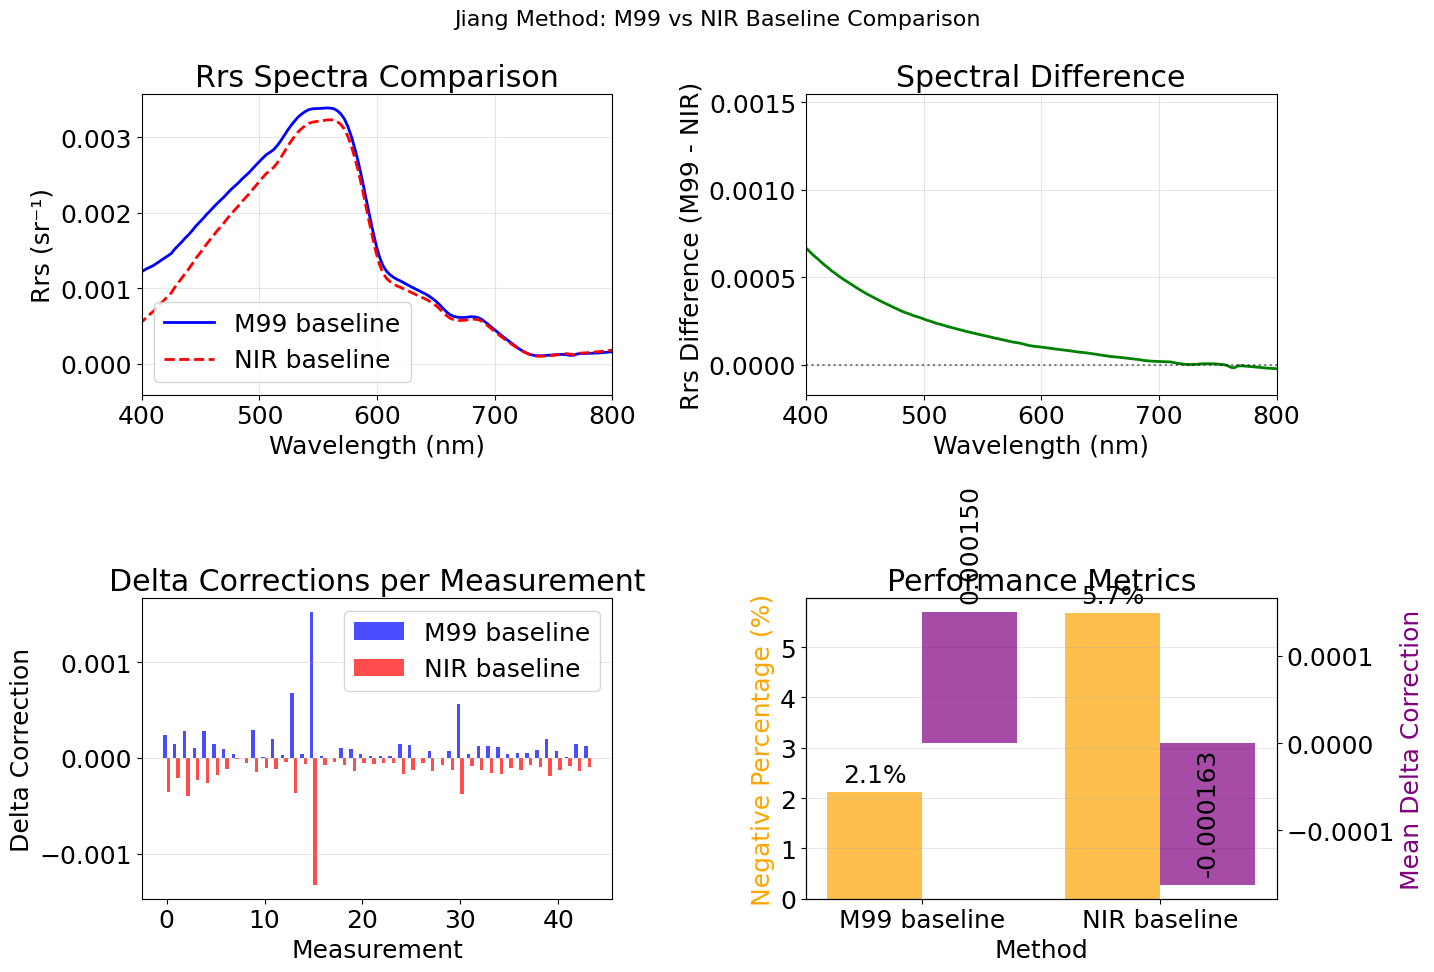

In [12]:
# Test Jiang Method: M99 baseline vs NIR ratio baseline comparison
if df is not None and wl is not None:
    print("=== Jiang Method Baseline Comparison ===")
    
    Lt_data = df['Lt']
    Lsky_data = df['Lsky']
    Ed_data = df['Ed']
    
    # Test 1: Jiang with M99 baseline (correct approach)
    try:
        print("Testing Jiang with M99 baseline...")
        rrs_jiang_m99, delta_jiang_m99 = get_rho_jiang(wl, Lt_data, Lsky_data, Ed_data, use_mobley_rho=True)
        
        if rrs_jiang_m99 is not None:
            neg_pct_m99 = (np.sum(rrs_jiang_m99 < 0) / rrs_jiang_m99.size) * 100
            mean_delta_m99 = np.nanmean(delta_jiang_m99)
            print(f"✓ Jiang (M99 baseline): {neg_pct_m99:.1f}% negative, δ={mean_delta_m99:.6f}")
        else:
            print("❌ Jiang (M99 baseline) failed")
            rrs_jiang_m99, delta_jiang_m99 = None, None
            
    except Exception as e:
        print(f"❌ Jiang (M99 baseline) error: {e}")
        rrs_jiang_m99, delta_jiang_m99 = None, None
    
    # Test 2: Jiang with NIR ratio baseline (fallback approach)
    try:
        print("Testing Jiang with NIR ratio baseline...")
        rrs_jiang_nir, delta_jiang_nir = get_rho_jiang(wl, Lt_data, Lsky_data, Ed_data, use_mobley_rho=False)
        
        if rrs_jiang_nir is not None:
            neg_pct_nir = (np.sum(rrs_jiang_nir < 0) / rrs_jiang_nir.size) * 100
            mean_delta_nir = np.nanmean(delta_jiang_nir)
            print(f"✓ Jiang (NIR baseline): {neg_pct_nir:.1f}% negative, δ={mean_delta_nir:.6f}")
        else:
            print("❌ Jiang (NIR baseline) failed")
            rrs_jiang_nir, delta_jiang_nir = None, None
            
    except Exception as e:
        print(f"❌ Jiang (NIR baseline) error: {e}")
        rrs_jiang_nir, delta_jiang_nir = None, None
    
    # Compare the two approaches if both succeeded
    if rrs_jiang_m99 is not None and rrs_jiang_nir is not None:
        print(f"\n=== Baseline Comparison Summary ===")
        print(f"M99 baseline:  {neg_pct_m99:.1f}% negative, δ={mean_delta_m99:.6f}")
        print(f"NIR baseline:  {neg_pct_nir:.1f}% negative, δ={mean_delta_nir:.6f}")
        print(f"Delta difference: {abs(mean_delta_m99 - mean_delta_nir):.6f}")
        
        # Visualization comparison
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        fig.suptitle('Jiang Method: M99 vs NIR Baseline Comparison', fontsize=16)
        
        # Plot 1: Rrs spectra comparison
        ax1 = axes[0, 0]
        mean_rrs_m99 = np.mean(rrs_jiang_m99, axis=0)
        mean_rrs_nir = np.mean(rrs_jiang_nir, axis=0)
        
        ax1.plot(wl, mean_rrs_m99, 'b-', linewidth=2, label='M99 baseline')
        ax1.plot(wl, mean_rrs_nir, 'r--', linewidth=2, label='NIR baseline')
        ax1.set_xlabel('Wavelength (nm)')
        ax1.set_ylabel('Rrs (sr⁻¹)')
        ax1.set_title('Rrs Spectra Comparison')
        ax1.grid(True, alpha=0.3)
        ax1.legend()
        ax1.set_xlim(400, 800)
        
        # Plot 2: Difference between methods
        ax2 = axes[0, 1]
        rrs_diff = mean_rrs_m99 - mean_rrs_nir
        ax2.plot(wl, rrs_diff, 'g-', linewidth=2)
        ax2.axhline(y=0, color='k', linestyle=':', alpha=0.5)
        ax2.set_xlabel('Wavelength (nm)')
        ax2.set_ylabel('Rrs Difference (M99 - NIR)')
        ax2.set_title('Spectral Difference')
        ax2.grid(True, alpha=0.3)
        ax2.set_xlim(400, 800)
        
        # Plot 3: Delta corrections comparison
        ax3 = axes[1, 0]
        x_pos = np.arange(len(delta_jiang_m99))
        width = 0.35
        
        ax3.bar(x_pos - width/2, delta_jiang_m99, width, label='M99 baseline', alpha=0.7, color='blue')
        ax3.bar(x_pos + width/2, delta_jiang_nir, width, label='NIR baseline', alpha=0.7, color='red')
        ax3.set_xlabel('Measurement')
        ax3.set_ylabel('Delta Correction')
        ax3.set_title('Delta Corrections per Measurement')
        ax3.legend()
        ax3.grid(True, alpha=0.3, axis='y')
        
        # Plot 4: Statistics summary
        ax4 = axes[1, 1]
        methods = ['M99 baseline', 'NIR baseline']
        neg_percentages = [neg_pct_m99, neg_pct_nir]
        mean_deltas = [mean_delta_m99, mean_delta_nir]
        
        x = np.arange(len(methods))
        ax4_twin = ax4.twinx()
        
        bars1 = ax4.bar(x - 0.2, neg_percentages, 0.4, label='Negative %', alpha=0.7, color='orange')
        bars2 = ax4_twin.bar(x + 0.2, mean_deltas, 0.4, label='Mean δ', alpha=0.7, color='purple')
        
        ax4.set_xlabel('Method')
        ax4.set_ylabel('Negative Percentage (%)', color='orange')
        ax4_twin.set_ylabel('Mean Delta Correction', color='purple')
        ax4.set_title('Performance Metrics')
        ax4.set_xticks(x)
        ax4.set_xticklabels(methods)
        ax4.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, val in zip(bars1, neg_percentages):
            ax4.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.1,
                    f'{val:.1f}%', ha='center', va='bottom')
        for bar, val in zip(bars2, mean_deltas):
            ax4_twin.text(bar.get_x() + bar.get_width()/2., bar.get_height() + 0.00001,
                         f'{val:.6f}', ha='center', va='bottom', rotation=90)
        
        plt.tight_layout()
        plt.show()
        
    else:
        print("Cannot compare - one or both methods failed")
        
else:
    print("Cannot test Jiang comparison - data not available")

In [13]:
# Apply All AWR Methods - Simplified and Standardized Approach
def calculate_method_results(method_name, df, wl_grid, vza, azi, ws, aot):
    """
    Standardized function to calculate Rrs and rho for any method.
    Returns consistent results regardless of method type.
    """
    try:
        if method_name in ['M99', 'M2015', 'OSOAA']:
            # Standard AWR processing methods - map display names to internal names
            method_mapping = {'M99': 'M99', 'M2015': 'M15', 'OSOAA': 'osoaa'}
            internal_method = method_mapping[method_name]
            
            test_awr = awr_process(df, wl_grid, name, idpr)
            
            # Get the clean data and parameters (following process.py logic)
            clean = df
            Lt, Lsky, Ed, sza = clean.Lt.values, clean.Lsky.values, clean.Ed.values, clean.sza.values
            
            # Suppress all output from process_wrapper
            import io
            import sys
            from contextlib import redirect_stdout, redirect_stderr
            
            f_out = io.StringIO()
            f_err = io.StringIO()
            with redirect_stdout(f_out), redirect_stderr(f_err):
                # Call process_wrapper directly to get both Rrs and rho
                Rrs, rho = test_awr.process_wrapper(wl_grid, clean, clean.sza, 
                                                  vza=[vza], azi=[azi], ws=[ws], aot=[aot], 
                                                  method=internal_method)
            
            # Convert to numpy arrays for consistent handling
            rrs_array = Rrs.values if hasattr(Rrs, 'values') else np.array(Rrs)
            rho_array = rho.values if hasattr(rho, 'values') else np.array(rho)
            
            # Ensure 2D arrays
            if len(rrs_array.shape) == 1:
                rrs_array = rrs_array.reshape(1, -1)
            if len(rho_array.shape) == 1:
                rho_array = rho_array.reshape(1, -1)
            
        elif method_name == 'Harmel':
            # Harmel 2023 method - Use EXACT same logic as Cell 13
            if 'ssrr' not in globals():
                print(f"  {method_name}: LUT not available (ssrr)")
                return None
                    
            Lt_data = df['Lt']
            Lsky_data = df['Lsky'] 
            Ed_data = df['Ed']
            
            # Use EXACT same parameters as Cell 13
            test_sza = 45
            test_vza = 40  
            test_azi = 135
            test_ws = 2
            test_aot = 0.1
            test_model = 'MACL_rh70'
            
            # Call get_rrs_harmel2023_final exactly like Cell 13
            rrs_array, rho_array, actual_wl = get_rrs_harmel2023_final(
                wl, Lt_data, Lsky_data, Ed_data, test_sza, test_vza, test_azi, test_ws, test_aot, test_model)
            
            if rrs_array is None:
                print(f"  {method_name}: Calculation failed")
                return None
                
        elif method_name == 'UV+NIR':
            # UV+NIR spline method
            Lt_data = df['Lt']
            Lsky_data = df['Lsky']
            Ed_data = df['Ed']
            
            import io
            import sys
            from contextlib import redirect_stdout, redirect_stderr
            
            f_out = io.StringIO()
            f_err = io.StringIO()
            with redirect_stdout(f_out), redirect_stderr(f_err):
                rrs_array, rho_spectral = get_rho_uv_nir_spline(wl_grid, Lt_data, Lsky_data, Ed_data)
            
            if rrs_array is None:
                print(f"  {method_name}: Calculation failed")
                return None
                
            # For UV+NIR, rho_spectral needs to be converted to contribution
            sky_norm = Lsky_data.values / Ed_data.values
            if len(sky_norm.shape) == 1:
                sky_norm = sky_norm.reshape(1, -1)
            rho_array = rho_spectral * sky_norm
            
        elif method_name == 'Kutser':
            # Kutser method
            Lt_data = df['Lt']
            Lsky_data = df['Lsky']
            Ed_data = df['Ed']
            
            import io
            import sys
            from contextlib import redirect_stdout, redirect_stderr
            
            f_out = io.StringIO()
            f_err = io.StringIO()
            with redirect_stdout(f_out), redirect_stderr(f_err):
                rrs_array, glint_estimate = get_rho_kutser(wl_grid, Lt_data, Lsky_data, Ed_data)
            
            if rrs_array is None:
                print(f"  {method_name}: Calculation failed")
                return None
                
            rho_array = glint_estimate
            
        elif method_name == 'Jiang':
            # Jiang method
            Lt_data = df['Lt']
            Lsky_data = df['Lsky']
            Ed_data = df['Ed']
            
            import io
            import sys
            from contextlib import redirect_stdout, redirect_stderr
            
            f_out = io.StringIO()
            f_err = io.StringIO()
            with redirect_stdout(f_out), redirect_stderr(f_err):
                rrs_array, delta_correction = get_rho_jiang(wl_grid, Lt_data, Lsky_data, Ed_data, use_mobley_rho=False)
            
            if rrs_array is None:
                print(f"  {method_name}: Calculation failed")
                return None
                
            rho_array = delta_correction
            
        else:
            print(f"  {method_name}: Unknown method")
            return None
        
        # Calculate negative percentage
        neg_pct = (np.sum(rrs_array < 0) / rrs_array.size) * 100
        
        # Return standardized results
        return {
            'Rrs': rrs_array,
            'rho': rho_array, 
            'neg_pct': neg_pct,
            'method': method_name
        }
        
    except Exception as e:
        print(f"  {method_name}: Error - {e}")
        import traceback
        traceback.print_exc()
        return None

# ================================
# MAIN PROCESSING
# ================================

if df is not None and wl is not None:
    print(f"=== SIMPLIFIED AWR METHOD COMPARISON ===")
    print(f"Using wavelength grid: {len(wl)} points ({wl.min():.0f}-{wl.max():.0f} nm)")
    
    # Clear any previous results to avoid contamination
    if 'methods_results' in globals():
        del methods_results
    methods_results = {}
    
    # Define methods to process
    methods_to_process = ['M99', 'M2015', 'OSOAA', 'Harmel', 'UV+NIR', 'Kutser', 'Jiang']
    
    # Process each method using standardized function
    for method in methods_to_process:
        print(f"\nProcessing {method}...")
        result = calculate_method_results(method, df, wl, vza, azi, ws, aot)
        
        if result is not None:
            methods_results[method] = result
            
            # Print results with consistent formatting
            rho_mean = np.nanmean(result['rho'])
            if method in ['M99', 'M2015', 'OSOAA']:
                print(f"{method}: {result['neg_pct']:.1f}% negative, ρ={rho_mean:.4f}")
            elif method == 'Jiang':
                print(f"{method}: {result['neg_pct']:.1f}% negative, δ={rho_mean:.6f}")
            else:
                print(f"{method}: {result['neg_pct']:.1f}% negative, ρ̃={rho_mean:.4f}")
    
    print(f"\n=== SUMMARY ===")
    print(f"Successfully processed {len(methods_results)} methods:")
    for method, result in methods_results.items():
        print(f"  {method}: {result['neg_pct']:.1f}% negative")
    
else:
    print("❌ Cannot process - data not available")
    methods_results = {}

=== SIMPLIFIED AWR METHOD COMPARISON ===
Using wavelength grid: 211 points (320-950 nm)

Processing M99...
M99: 1.0% negative, ρ=0.0269

Processing M2015...
M99: 1.0% negative, ρ=0.0269

Processing M2015...
M2015: 6.8% negative, ρ=0.0305

Processing OSOAA...
M2015: 6.8% negative, ρ=0.0305

Processing OSOAA...


OSOAA: 0.3% negative, ρ=0.0268

Processing Harmel...
Harmel: 7.6% negative, ρ̃=0.0323

Processing UV+NIR...
UV+NIR: 28.7% negative, ρ̃=0.0018

Processing Kutser...
Kutser: 43.8% negative, ρ̃=0.0020

Processing Jiang...
Jiang: 5.7% negative, δ=-0.000163

=== SUMMARY ===
Successfully processed 7 methods:
  M99: 1.0% negative
  M2015: 6.8% negative
  OSOAA: 0.3% negative
  Harmel: 7.6% negative
  UV+NIR: 28.7% negative
  Kutser: 43.8% negative
  Jiang: 5.7% negative


/tmp/ipykernel_38233/1205280204.py:42: RuntimeWarning: Mean of empty slice
  mean_rho = np.nanmean(rho_values, axis=0)


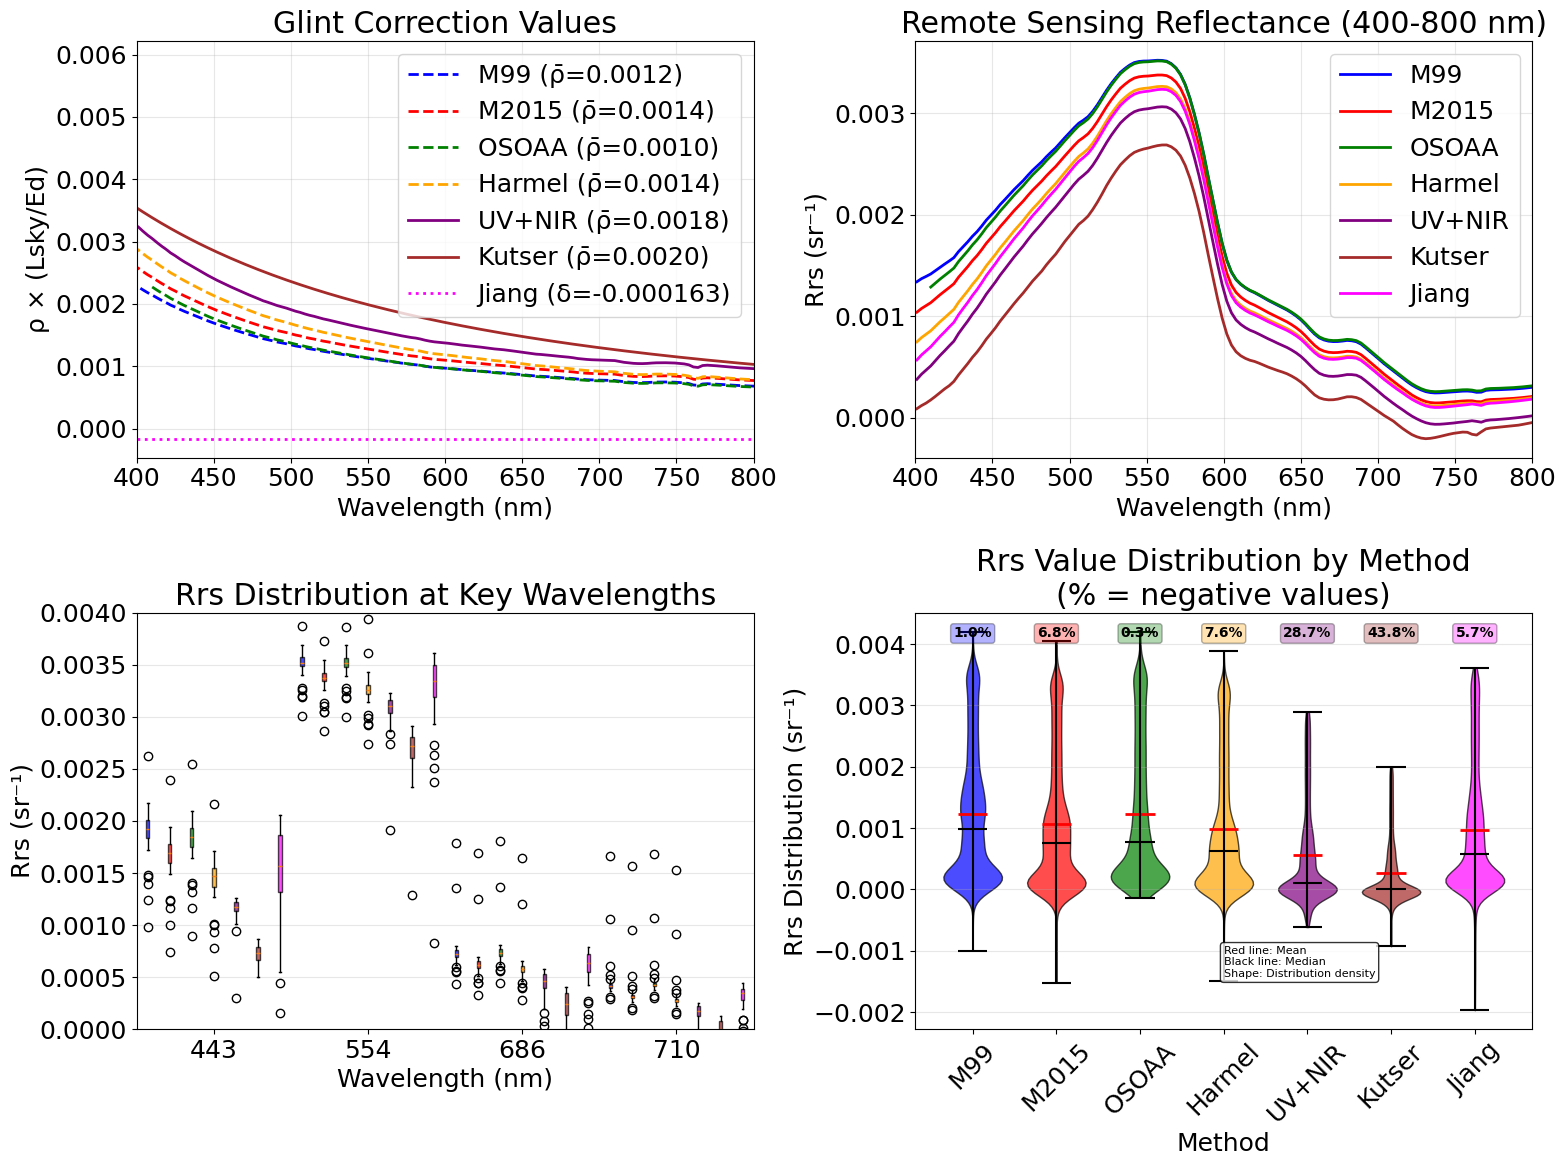

In [14]:
# Method Comparison Visualization
if 'methods_results' in locals() and methods_results:
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    # Expanded color palette with brighter, more visible colors for all 7 methods
    colors = ['blue', 'red', 'green', 'orange', 'purple', 'brown', 'magenta', 'gray', 'olive', 'cyan']
    
    # Panel 1: Rho correction values (top-left) - Show actual rho values
    ax1 = axes[0, 0]
    
    # Get sky normalization factor (Lsky/Ed) for proper rho calculation
    Lt_data = df['Lt']
    Lsky_data = df['Lsky']
    Ed_data = df['Ed']
    sky_norm = Lsky_data.values / Ed_data.values
    if len(sky_norm.shape) == 1:
        sky_norm = sky_norm.reshape(1, -1)
    mean_sky_norm = np.mean(sky_norm, axis=0)
    
    for i, (method, data) in enumerate(methods_results.items()):
        rho_values = data['rho']
        color = colors[i % len(colors)]
        
        if method in ['UV+NIR', 'Kutser']:
            # These already contain rho * (Lsky/Ed), show directly
            mean_rho_contribution = np.nanmean(rho_values, axis=0)
            ax1.plot(awr.wl, mean_rho_contribution, color=color, 
                    label=f'{method} (ρ̄={np.nanmean(mean_rho_contribution):.4f})', linewidth=2)
        elif method == 'Jiang':
            # Jiang method uses delta corrections (scalar values)
            mean_delta = np.nanmean(rho_values)
            # Plot as horizontal line since delta is applied to all wavelengths
            ax1.axhline(y=mean_delta, color=color, linestyle=':', 
                       label=f'{method} (δ={mean_delta:.6f})', linewidth=2)
        elif method == 'Harmel2023':
            # Harmel method: multiply rho by (Lsky/Ed) similar to M99/M2015/OSOAA
            mean_rho = np.nanmean(rho_values, axis=0)
            rho_contribution = mean_rho * mean_sky_norm
            ax1.plot(awr.wl, rho_contribution, color=color, linestyle='-', 
                    label=f'{method} (ρ̄={np.nanmean(rho_contribution):.4f})', linewidth=2)
        else:
            # For M99, M2015, OSOAA: multiply rho by (Lsky/Ed)
            mean_rho = np.nanmean(rho_values, axis=0)
            rho_contribution = mean_rho * mean_sky_norm
            
            # Always plot the spectral rho_contribution, even if rho itself is constant
            # Because constant rho * spectral (Lsky/Ed) = spectral output
            ax1.plot(awr.wl, rho_contribution, color=color, linestyle='--', 
                    label=f'{method} (ρ̄={np.nanmean(rho_contribution):.4f})', linewidth=2)
    
    ax1.set_xlabel('Wavelength (nm)')
    ax1.set_ylabel('ρ × (Lsky/Ed)')
    ax1.set_title('Glint Correction Values')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    ax1.set_xlim(400, 800)
    
    # Panel 2: Rrs spectra (top-right) - Clean lines without std bands
    ax2 = axes[0, 1]
    wl_vis = (awr.wl >= 400) & (awr.wl <= 800)
    for i, (method, data) in enumerate(methods_results.items()):
        rrs_values = data['Rrs']
        mean_rrs = np.mean(rrs_values, axis=0)
        color = colors[i % len(colors)]
        
        # Use simple plot instead of add_curve to remove std deviation bands
        ax2.plot(awr.wl[wl_vis], mean_rrs[wl_vis], color=color, 
                label=method, linewidth=2)
    
    ax2.set_xlabel('Wavelength (nm)')
    ax2.set_ylabel('Rrs (sr⁻¹)')
    ax2.set_title('Remote Sensing Reflectance (400-800 nm)')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    ax2.set_xlim(400, 800)
    
    # Panel 3: Box plots at key wavelengths (bottom-left)
    ax3 = axes[1, 0]
    key_wl = [443, 555, 685, 710]
    key_indices = [np.argmin(np.abs(awr.wl - w)) for w in key_wl]
    
    box_data = []
    box_labels = []
    positions = []
    
    for wl_idx, target_wl in enumerate(key_wl):
        wl_pos = key_indices[wl_idx]
        for method_idx, (method, data) in enumerate(methods_results.items()):
            rrs_values = data['Rrs']
            values_at_wl = rrs_values[:, wl_pos]
            box_data.append(values_at_wl)
            box_labels.append(f'{method}')
            positions.append(wl_idx * len(methods_results) + method_idx)
    
    bp = ax3.boxplot(box_data, positions=positions, patch_artist=True, widths=0.15)
    
    for patch, method_idx in zip(bp['boxes'], range(len(box_data))):
        color_idx = method_idx % len(methods_results)
        patch.set_facecolor(colors[color_idx % len(colors)])
        patch.set_alpha(0.7)
    
    ax3.set_xlabel('Wavelength (nm)')
    ax3.set_ylabel('Rrs (sr⁻¹)')
    ax3.set_title('Rrs Distribution at Key Wavelengths')
    
    # Set x-tick positions and labels
    center_positions = [i * len(methods_results) + (len(methods_results) - 1) / 2 for i in range(len(key_wl))]
    ax3.set_xticks(center_positions)
    ax3.set_xticklabels([f'{awr.wl[idx]:.0f}' for idx in key_indices])
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Set focused Y-axis range for better resolution
    ax3.set_ylim(0.000, 0.004)
    
    # Remove legend from Panel 3 since Panel 4 shows method names clearly
    # This reduces clutter and improves readability
    
    # Panel 4: Method performance with violin plots (bottom-right)
    ax4 = axes[1, 1]
    method_names = list(methods_results.keys())
    neg_percentages = [methods_results[m]['neg_pct'] for m in method_names]
    
    # Create violin plot data - use flattened Rrs values for each method
    violin_data = []
    violin_labels = []
    violin_colors = []
    
    for i, (method, data) in enumerate(methods_results.items()):
        rrs_flat = data['Rrs'].flatten()
        # Remove NaN values first
        rrs_flat = rrs_flat[~np.isnan(rrs_flat)]
        
        if len(rrs_flat) > 0:
            # Remove extreme outliers for better visualization
            q1, q3 = np.percentile(rrs_flat, [25, 75])
            iqr = q3 - q1
            if iqr > 0:
                lower_bound = q1 - 1.5 * iqr
                upper_bound = q3 + 1.5 * iqr
                filtered_rrs = rrs_flat[(rrs_flat >= lower_bound) & (rrs_flat <= upper_bound)]
                
                # Ensure we have enough data points for violin plot
                if len(filtered_rrs) < 5:
                    filtered_rrs = rrs_flat  # Use all data if too few points after filtering
            else:
                filtered_rrs = rrs_flat
        else:
            # Fallback if no valid data
            filtered_rrs = np.array([0.0])
        
        violin_data.append(filtered_rrs)
        violin_labels.append(method)
        violin_colors.append(colors[i % len(colors)])
    
    # Create violin plots
    try:
        parts = ax4.violinplot(violin_data, positions=range(len(method_names)), 
                              showmeans=True, showmedians=True, widths=0.7)
        
        # Customize violin plot colors
        for i, pc in enumerate(parts['bodies']):
            pc.set_facecolor(violin_colors[i])
            pc.set_alpha(0.7)
            pc.set_edgecolor('black')
            pc.set_linewidth(1)
        
        # Customize other elements
        parts['cmeans'].set_color('red')
        parts['cmeans'].set_linewidth(2)
        parts['cmedians'].set_color('black')
        parts['cmedians'].set_linewidth(1.5)
        parts['cbars'].set_color('black')
        parts['cmins'].set_color('black')
        parts['cmaxes'].set_color('black')
        
        # Add negative percentage labels above violins
        for i, (method, neg_pct) in enumerate(zip(method_names, neg_percentages)):
            ax4.text(i, ax4.get_ylim()[1] * 0.9, f'{neg_pct:.1f}%', 
                    ha='center', va='bottom', fontsize=10, fontweight='bold',
                    bbox=dict(boxstyle='round,pad=0.2', facecolor=violin_colors[i], alpha=0.3))
        
        # Add legend explaining the violin plot elements
        legend_text = 'Red line: Mean\nBlack line: Median\nShape: Distribution density'
        ax4.text(0.5, 0.2, legend_text, transform=ax4.transAxes, 
                fontsize=8, verticalalignment='top',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
                
    except Exception as e:
        # Fallback to bar chart if violin plot fails
        print(f"Violin plot failed, using bar chart: {e}")
        bars = ax4.bar(range(len(method_names)), neg_percentages, 
                      color=violin_colors, alpha=0.7)
        
        for bar, pct in zip(bars, neg_percentages):
            height = bar.get_height()
            ax4.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{pct:.1f}%', ha='center', va='bottom', fontsize=10)
    
    ax4.set_xlabel('Method')
    ax4.set_ylabel('Rrs Distribution (sr⁻¹)')
    ax4.set_title('Rrs Value Distribution by Method\n(% = negative values)')
    ax4.set_xticks(range(len(method_names)))
    ax4.set_xticklabels(method_names, rotation=45)
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("No method results available for visualization")

## SABER_fast Integration for Bio-optical Parameter Inversion

This section demonstrates the integration of R-based SABER_fast package for retrieving bio-optical parameters (chlorophyll, CDOM absorption, particulate backscatter) from processed AWR remote sensing reflectance data.

In [15]:
# SABER Inversion Individual Spectra
import numpy as np
import pandas as pd
import warnings
from tqdm import tqdm

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("SABER Inversion on TRIOS AWR data")
print("="*65)

# Use the Harmel method data
method_name = 'Harmel'
rrs_all = methods_results[method_name]['Rrs']
wl = wl_common

# Apply wavelength filtering (400-770 nm)
wl_mask = (wl >= 400) & (wl <= 770)
wl_filtered = wl[wl_mask]
rrs_filtered = rrs_all[:, wl_mask]

# R integration setup
try:
    import rpy2.robjects as ro
    from rpy2.robjects.packages import importr
    import rpy2.rinterface_lib.callbacks
    
    # Suppress R console output
    def no_console_print(x):
        pass
    
    rpy2.rinterface_lib.callbacks.consolewrite_print = no_console_print
    rpy2.rinterface_lib.callbacks.consolewrite_warnerror = no_console_print
    
    # Load packages quietly
    saber = importr('SABER')
    tibble = importr('tibble')
    #print("SABER package loaded successfully")
    
    # Configure parallel processing and reproducibility
    # ro.r('options(mc.cores=parallel::detectCores())')
    # ro.r('set.seed(12345)')
    # n_cores = ro.r('parallel::detectCores()-2')[0]
    # print(f"Parallel processing enabled: {int(n_cores)} CPU cores")
    
    # Fixed parameters for optically deep water
    mean_sza = sza_values.mean()
    
    r_code = f'''
    par_fixed <- c(
      "water_type" = 2,
      "theta_view" = 40,
      "theta_sun" = {mean_sza},
      "h_w" = NULL,
      "r_rs_b_saccharina" = NULL,
      "r_rs_b_cca" = NULL,
      "r_rs_b_gravel" = NULL
    )
    '''
    ro.r(r_code)
    par_fixed = ro.r['par_fixed']

    iter_mcmc = 20000 
    burnin_mcmc = 4000

    # Storage for results
    individual_results = []
    failed_spectra = []
    
    #print("\nProcessing individual spectra...")
    # print("Configuration Summary:")
    # print("="*50)
    # print(f"• Water type: Optically deep water")
    # print(f"• Wavelength range: 400-750 nm")
    # print(f"• MCMC iterations: {iter_mcmc:,}")
    # print(f"• Burn-in period: {burnin_mcmc:,}")
    # #print(f"• Parallel cores: {int(n_cores)}")
    # #print(f"• Random seed: 12345")
    # print("\nFixed Parameters:")
    # print(f"• Water type: {int(par_fixed.rx2('water_type')[0])}")
    # print(f"• View angle (θᵥ): {int(par_fixed.rx2('theta_view')[0])}°")
    # print(f"• Solar zenith angle (θₛ): {float(par_fixed.rx2('theta_sun')[0]):.1f}°")
    # print(f"• Water depth (h_w): NULL (deep water)")
    # print(f"• Bottom reflectance: NULL (deep water)")
    # print("="*50)
    
    # Process each spectrum individually
    for i in tqdm(range(rrs_filtered.shape[0]), desc="SABER inversions"):
        spectrum = rrs_filtered[i, :]
        
        # Data quality check
        valid_mask = np.isfinite(spectrum) & (spectrum > 0)
        n_valid = np.sum(valid_mask)
        
        if n_valid < 10:  # Require at least 10 valid points
            failed_spectra.append({
                'spectrum_id': i,
                'reason': 'insufficient_valid_data',
                'n_valid': n_valid
            })
            continue
            
        # Clean the spectrum
        wl_clean = wl_filtered[valid_mask]
        rrs_clean = spectrum[valid_mask]
        
        # Replace any remaining negatives/zeros with small positive value
        rrs_clean[rrs_clean <= 0] = 1e-6
        
        try:
            # Create R data for this spectrum
            rrs_data = tibble.tibble(
                wavelength=ro.FloatVector(wl_clean),
                rrs_0m=saber.rrs_0p_to_0m(ro.FloatVector(rrs_clean))
            )
            
            # Suppress R output during MCMC
            ro.r('sink(tempfile())')
            
            # Run MCMC with reduced iterations for faster processing
            mcmc_result = saber.inverse_mcmc(
                rrs=rrs_data,
                forward_model="am03",
                par_inversed=ro.StrVector(['chl', 'a_g_440', 'a_g_s', 'bb_p_550', 'bb_p_gamma', 'sd']),
                par_fixed=par_fixed,
                prior=ro.NULL,
                lower=ro.FloatVector([0.1, 0.01, 0.002, 0.001, 0.2, 0.001]),
                upper=ro.FloatVector([50.0, 5.0, 0.022, 0.1, 1.0, 10.0]),
                best=ro.NULL,
                iterations=20000,  # Reduced for faster processing
                burnin=4000,
                sampler="DEzs"
            )
            
            ro.r('sink()')  # Restore normal R output
            
            # Extract parameters with error handling
            try:
                param_values = {
                    'spectrum_id': i,
                    'chl': float(mcmc_result[0]),
                    'a_g_440': float(mcmc_result[1]),
                    'a_g_s': float(mcmc_result[2]),
                    'bb_p_550': float(mcmc_result[3]),
                    'bb_p_gamma': float(mcmc_result[4]),
                    'sd': float(mcmc_result[5]),
                    'chl_std': float(mcmc_result[6]),
                    'a_g_440_std': float(mcmc_result[7]),
                    'a_g_s_std': float(mcmc_result[8]),
                    'bb_p_550_std': float(mcmc_result[9]),
                    'bb_p_gamma_std': float(mcmc_result[10]),
                    'sd_std': float(mcmc_result[11])
                }
                
                individual_results.append(param_values)
                
            except Exception as param_error:
                failed_spectra.append({
                    'spectrum_id': i,
                    'reason': 'parameter_extraction_failed',
                    'error': str(param_error)
                })
                continue
                
        except Exception as e:
            failed_spectra.append({
                'spectrum_id': i,
                'reason': 'mcmc_failed',
                'error': str(e)
            })
            continue

    # Results summary
    print(f"\nInversion Results Summary:")
    print(f"  Successful inversions: {len(individual_results)}")
    print(f"  Failed inversions: {len(failed_spectra)}")
    print(f"  Success rate: {len(individual_results)/(len(individual_results)+len(failed_spectra))*100:.1f}%")

    # Create DataFrame for analysis
    if len(individual_results) > 0:
        results_df = pd.DataFrame(individual_results)
        
        # Statistical analysis
        params = ['chl', 'a_g_440', 'a_g_s', 'bb_p_550', 'bb_p_gamma', 'sd']
        param_labels = ['Chlorophyll', 'CDOM abs. (440nm)', 'CDOM slope', 'Part. backscatter (550nm)', 'Backscatter slope', 'Spectral deviation']
        param_units = ['mg/m³', 'm⁻¹', 'nm⁻¹', 'm⁻¹', '-', 'sr⁻¹']
        
        # Initialize param_stats dictionary
        param_stats = {}
        
        print(f"\nParameter Statistics (n={len(individual_results)}):")
        print("="*80)
        print(f"{'Parameter':<25} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10} {'Unit':<8}")
        print("-"*80)
        
        for param, label, unit in zip(params, param_labels, param_units):
            values = results_df[param].values
            param_stats[param] = {
                'mean': np.mean(values),
                'std': np.std(values),
                'min': np.min(values),
                'max': np.max(values),
                'median': np.median(values),
                'q25': np.percentile(values, 25),
                'q75': np.percentile(values, 75)
            }
            
            print(f"{label:<25} {param_stats[param]['mean']:<10.3f} {param_stats[param]['std']:<10.3f} "
                  f"{param_stats[param]['min']:<10.3f} {param_stats[param]['max']:<10.3f} {unit:<8}")
        
        print("="*80)
        print("SABER inversion completed successfully!")
        
    else:
        print("No successful inversions!")
        
except Exception as e:
    print(f"SABER batch processing failed: {e}")
    import traceback
    traceback.print_exc()

SABER Inversion on TRIOS AWR data


SABER inversions: 100%|██████████| 44/44 [02:01<00:00,  2.76s/it]


Inversion Results Summary:
  Successful inversions: 44
  Failed inversions: 0
  Success rate: 100.0%

Parameter Statistics (n=44):
Parameter                 Mean       Std        Min        Max        Unit    
--------------------------------------------------------------------------------
Chlorophyll               1.871      2.265      0.100      14.844     mg/m³   
CDOM abs. (440nm)         0.285      0.064      0.113      0.403      m⁻¹     
CDOM slope                0.013      0.006      0.002      0.022      nm⁻¹    
Part. backscatter (550nm) 0.007      0.001      0.005      0.013      m⁻¹     
Backscatter slope         0.845      0.285      0.201      1.000      -       
Spectral deviation        1.905      1.557      1.105      9.981      sr⁻¹    
SABER inversion completed successfully!


Visualizing results from 44 successful inversions


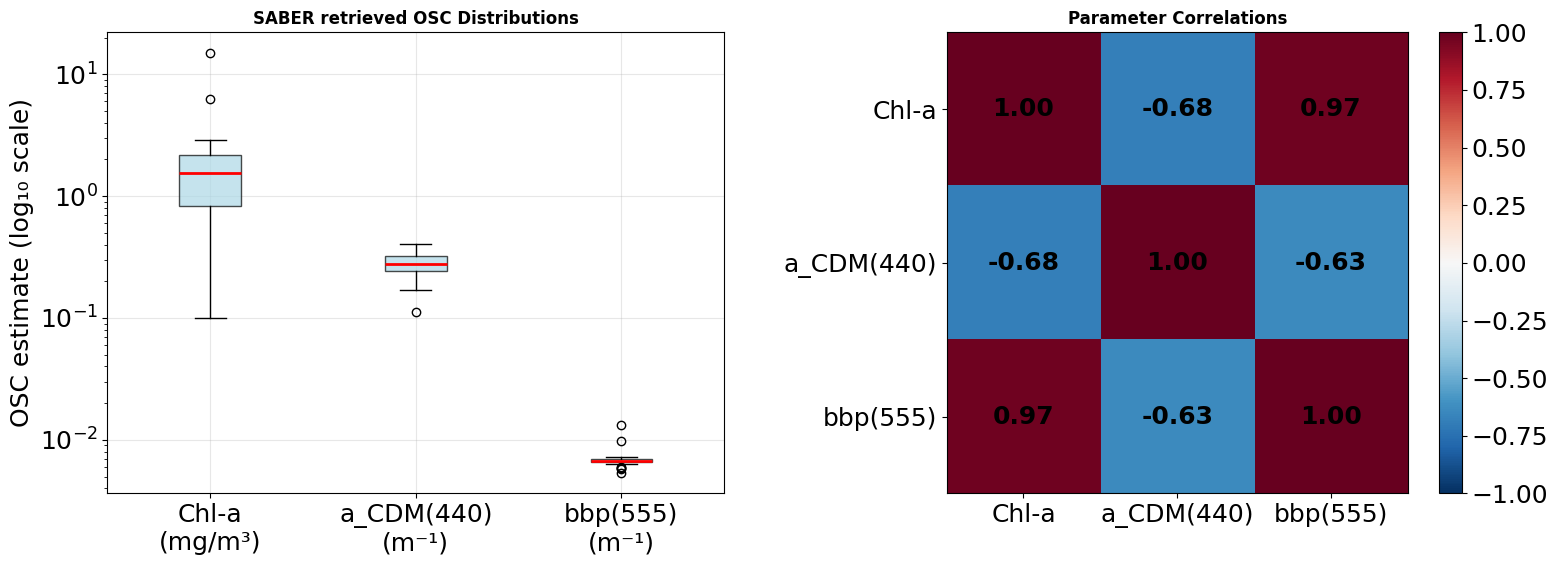

In [16]:
# SABER Results Visualization and Analysis
import matplotlib.pyplot as plt
import numpy as np

# Check if we have results from the inversion
if 'individual_results' not in locals() or len(individual_results) == 0:
    print("No SABER results found! Please run the inversion first.")
else:
    print(f"Visualizing results from {len(individual_results)} successful inversions")
    
    # Visualization - Box plots and correlation matrix side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Box plots for main bio-optical parameters
    main_params = ['chl', 'a_g_440', 'bb_p_550']
    main_labels = ['Chl-a\n(mg/m³)', 'a_CDM(440)\n(m⁻¹)', 'bbp(555)\n(m⁻¹)']
    main_data = [results_df[param].values for param in main_params]
    
    bp = ax1.boxplot(main_data, labels=main_labels, patch_artist=True, 
                    boxprops=dict(facecolor='lightblue', alpha=0.7),
                    medianprops=dict(color='red', linewidth=2))

    ax1.set_title(f'SABER retrieved OSC Distributions', 
                 fontsize=12, fontweight='bold')
    ax1.set_ylabel('OSC estimate (log₁₀ scale)')
    ax1.set_yscale('log')  # Set logarithmic scale
    ax1.grid(True, alpha=0.3)
    
    # Parameter correlation matrix
    corr_params = ['chl', 'a_g_440', 'bb_p_550']
    corr_data = results_df[corr_params].corr()
    
    im = ax2.imshow(corr_data, cmap='RdBu_r', vmin=-1, vmax=1)
    ax2.set_xticks(range(len(corr_params)))
    ax2.set_yticks(range(len(corr_params)))
    ax2.set_xticklabels(['Chl-a', 'a_CDM(440)', 'bbp(555)'])
    ax2.set_yticklabels(['Chl-a', 'a_CDM(440)', 'bbp(555)'])
    ax2.set_title('Parameter Correlations', fontsize=12, fontweight='bold')
    
    # Add correlation values as text
    for i in range(len(corr_params)):
        for j in range(len(corr_params)):
            text = ax2.text(j, i, f'{corr_data.iloc[i, j]:.2f}',
                           ha="center", va="center", color="black", fontweight='bold')
    
    plt.colorbar(im, ax=ax2)
    
    plt.tight_layout()
    plt.show()
    

SABER Forward Simulation - Input vs Simulated Rrs Comparison
Running forward simulations...


Forward simulations:   0%|          | 0/44 [00:00<?, ?it/s]

Forward simulations: 100%|██████████| 44/44 [00:00<00:00, 843.16it/s]


Forward simulation results:
  Successful simulations: 44
  Failed simulations: 0
  Success rate: 100.0%


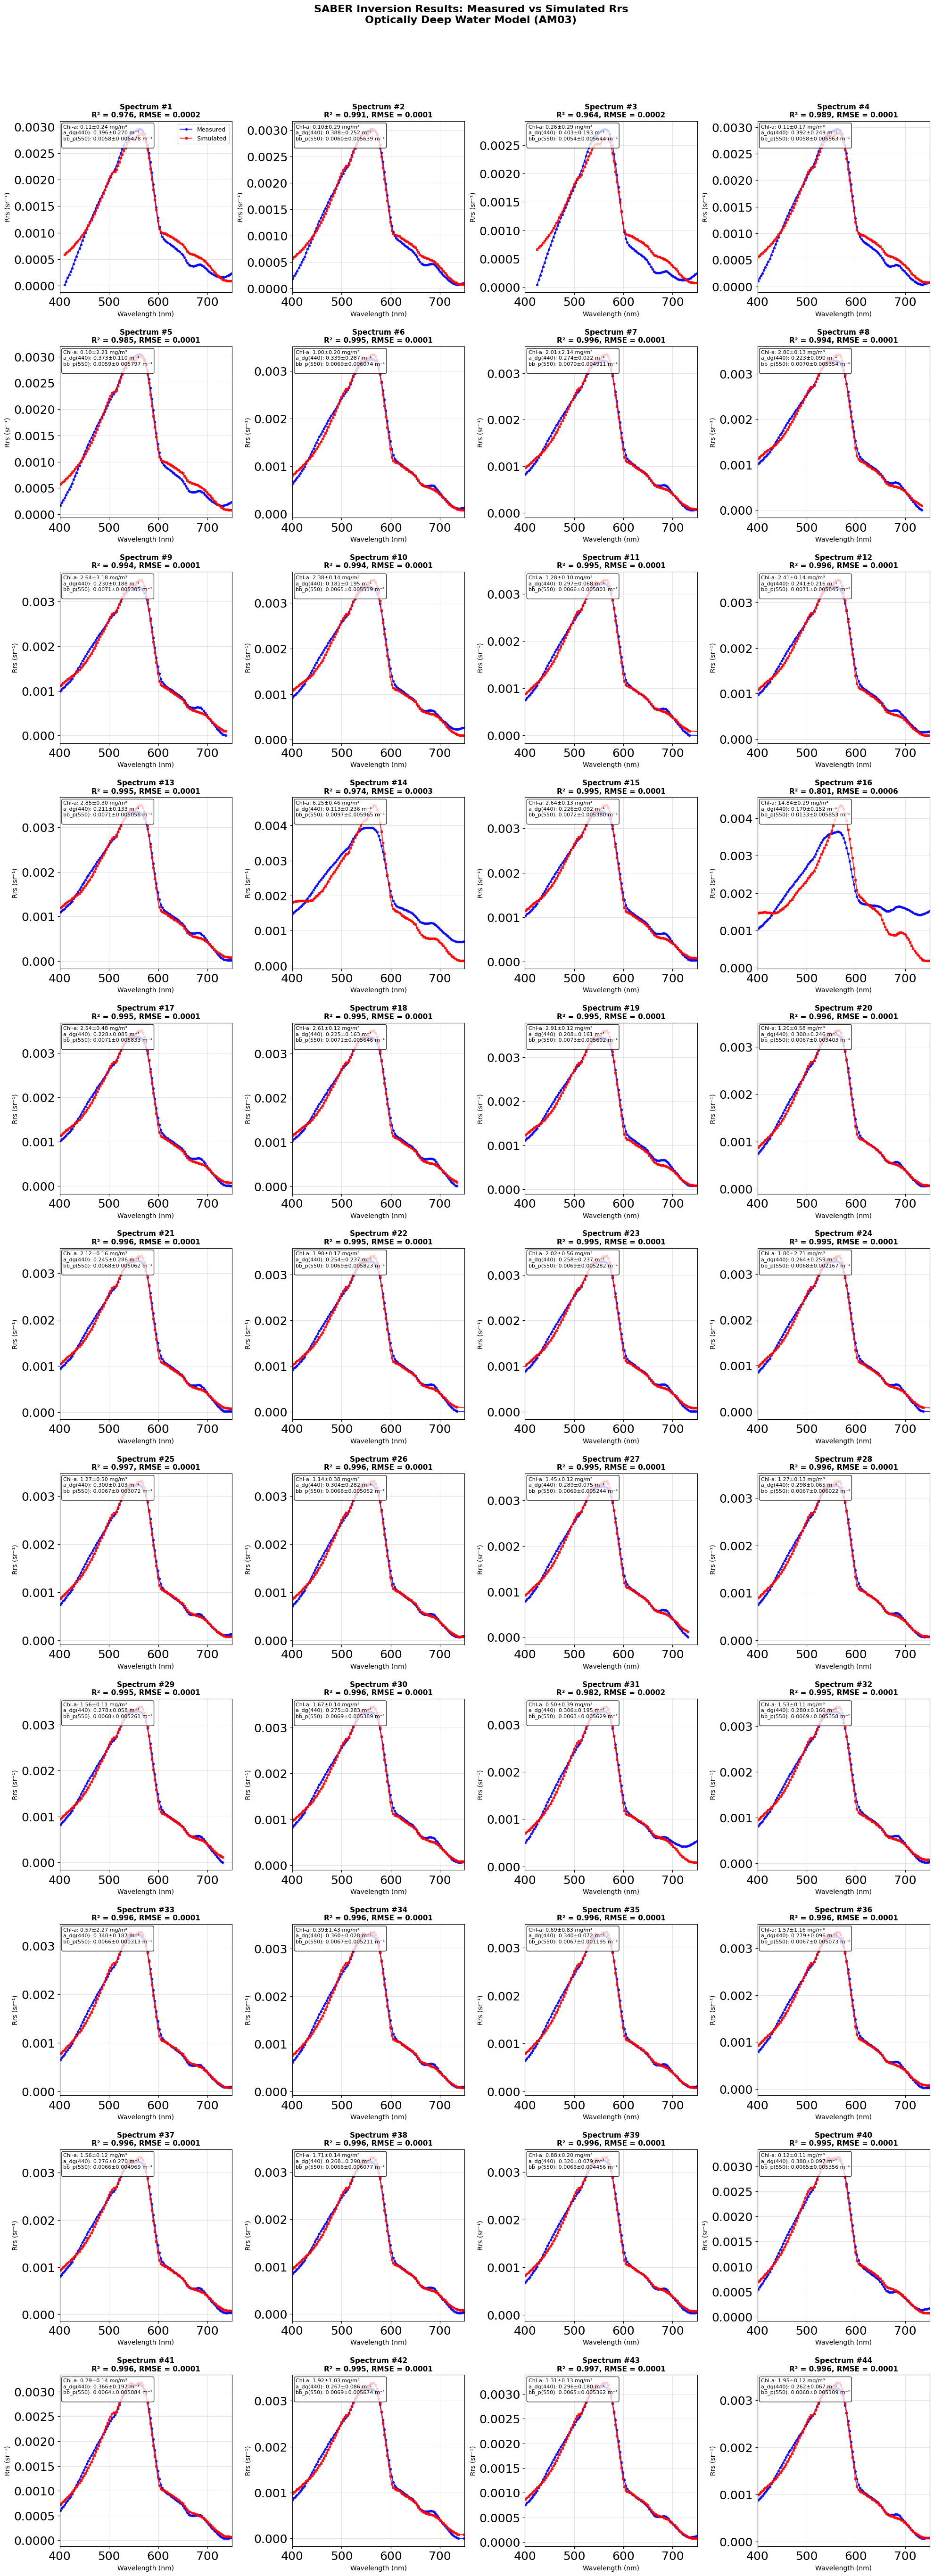


Overall Model Performance Statistics:
  Mean R²: 0.989 ± 0.029
  Mean RMSE: 0.0001 ± 0.0001 sr⁻¹
  Mean MAPE: 68.6% ± 214.0%


In [17]:
# Forward Simulation and Spectral Comparison
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("SABER Forward Simulation - Input vs Simulated Rrs Comparison")
print("="*65)

# Forward simulate Rrs for each retrieved parameter set
simulated_spectra = []
input_spectra = []
failed_forward = []

print("Running forward simulations...")

for i, result in enumerate(tqdm(individual_results, desc="Forward simulations")):
    try:
        # Get the original input spectrum for this result
        spectrum_id = result['spectrum_id']
        original_spectrum = rrs_filtered[spectrum_id, :]
        
        # Apply same quality filtering as in inversion
        valid_mask = np.isfinite(original_spectrum) & (original_spectrum > 0)
        if np.sum(valid_mask) < 10:
            continue
            
        wl_clean = wl_filtered[valid_mask]
        rrs_clean = original_spectrum[valid_mask]
        rrs_clean[rrs_clean <= 0] = 1e-6
        
        # Create named parameter vector for iop_from_oac
        par_vec = ro.FloatVector([
            result['chl'],
            result['a_g_440'], 
            result['bb_p_550'],
            result['a_g_s'],
            result['bb_p_gamma']
        ])
        par_vec.names = ro.StrVector(['chl', 'a_g_440', 'bb_p_550', 'a_g_s', 'bb_p_gamma'])
        
        # Calculate IOPs using SABER's iop_from_oac function
        iops = saber.iop_from_oac(
            wavelength=ro.FloatVector(wl_clean),
            par=par_vec
        )
        
        # Forward simulate Rrs using SABER's forward_am03 function (produces 0- Rrs)
        rrs_sim_0m = saber.forward_am03(
            wavelength=ro.FloatVector(wl_clean),
            iop=iops,
            water_type=int(par_fixed.rx2('water_type')[0]),
            theta_sun=float(par_fixed.rx2('theta_sun')[0]),
            theta_view=int(par_fixed.rx2('theta_view')[0]),
            h_w=ro.NULL,
            r_b=ro.NULL
        )
        
        # Convert simulated Rrs from 0- to 0+ for comparison with measured data
        rrs_sim = saber.rrs_0m_to_0p(rrs_sim_0m)
        
        # Store results
        simulated_spectra.append({
            'spectrum_id': spectrum_id,
            'wavelength': np.array(wl_clean),
            'rrs_measured': np.array(rrs_clean),
            'rrs_simulated': np.array(rrs_sim),
            'params': result
        })
        
    except Exception as e:
        failed_forward.append({
            'spectrum_id': result.get('spectrum_id', i),
            'error': str(e)
        })
        continue

print(f"\nForward simulation results:")
print(f"  Successful simulations: {len(simulated_spectra)}")
print(f"  Failed simulations: {len(failed_forward)}")
print(f"  Success rate: {len(simulated_spectra)/(len(simulated_spectra)+len(failed_forward))*100:.1f}%")

# Create comprehensive visualization (4 plots per row, 11 rows = 44 spectra)
if len(simulated_spectra) > 0:
    n_plots = len(simulated_spectra)
    n_cols = 4
    n_rows = int(np.ceil(n_plots / n_cols))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    fig.suptitle('SABER Inversion Results: Measured vs Simulated Rrs\nOptically Deep Water Model (AM03)', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    # Flatten axes array for easier indexing
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes_flat = axes.flatten()
    
    for i, spectrum_data in enumerate(simulated_spectra):
        ax = axes_flat[i]
        
        wl = spectrum_data['wavelength']
        rrs_meas = spectrum_data['rrs_measured']
        rrs_sim = spectrum_data['rrs_simulated']
        params = spectrum_data['params']
        
        # Plot measured vs simulated spectra
        ax.plot(wl, rrs_meas, 'o-', color='blue', markersize=3, linewidth=1.5, 
                label='Measured', alpha=0.8)
        ax.plot(wl, rrs_sim, 's-', color='red', markersize=3, linewidth=1.5, 
                label='Simulated', alpha=0.8)
        
        # Calculate R² and RMSE
        r2 = np.corrcoef(rrs_meas, rrs_sim)[0,1]**2
        rmse = np.sqrt(np.mean((rrs_meas - rrs_sim)**2))
        
        # Set axis properties
        ax.set_xlabel('Wavelength (nm)', fontsize=10)
        ax.set_ylabel('Rrs (sr⁻¹)', fontsize=10)
        ax.set_title(f'Spectrum #{spectrum_data["spectrum_id"]+1}\nR² = {r2:.3f}, RMSE = {rmse:.4f}', 
                    fontsize=11, fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.set_xlim(400, 750)
        
        # Add parameter annotations with uncertainties
        param_text = (f"Chl-a: {params['chl']:.2f}±{params.get('chl_std', 0):.2f} mg/m³\n"
                     f"a_dg(440): {params['a_g_440']:.3f}±{params.get('a_g_440_std', 0):.3f} m⁻¹\n"
                     #f"a_g_s: {params['a_g_s']:.4f}±{params.get('a_g_s_std', 0):.4f} nm⁻¹\n"
                     f"bb_p(550): {params['bb_p_550']:.4f}±{params.get('bb_p_550_std', 0):.6f} m⁻¹\n"
                     #f"γ: {params['bb_p_gamma']:.3f}±{params.get('bb_p_gamma_std', 0):.6f}\n"
                     )
        
        ax.text(0.02, 0.98, param_text, transform=ax.transAxes, fontsize=8,
                verticalalignment='top', horizontalalignment='left',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        # Add legend only to first plot
        if i == 0:
            ax.legend(loc='upper right', fontsize=9)
    
    # Hide unused subplots
    for j in range(len(simulated_spectra), len(axes_flat)):
        axes_flat[j].set_visible(False)
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()
    
    # Calculate overall statistics
    all_r2 = []
    all_rmse = []
    all_mape = []
    
    for spectrum_data in simulated_spectra:
        rrs_meas = spectrum_data['rrs_measured']
        rrs_sim = spectrum_data['rrs_simulated']
        
        r2 = np.corrcoef(rrs_meas, rrs_sim)[0,1]**2
        rmse = np.sqrt(np.mean((rrs_meas - rrs_sim)**2))
        mape = np.mean(np.abs((rrs_meas - rrs_sim) / rrs_meas)) * 100
        
        all_r2.append(r2)
        all_rmse.append(rmse)
        all_mape.append(mape)
    
    print(f"\nOverall Model Performance Statistics:")
    print(f"  Mean R²: {np.mean(all_r2):.3f} ± {np.std(all_r2):.3f}")
    print(f"  Mean RMSE: {np.mean(all_rmse):.4f} ± {np.std(all_rmse):.4f} sr⁻¹")
    print(f"  Mean MAPE: {np.mean(all_mape):.1f}% ± {np.std(all_mape):.1f}%")
    print("="*65)
    
else:
    print("No successful forward simulations to display!")

Creating side-by-side spectral comparison...
Using 44 spectra from forward simulation


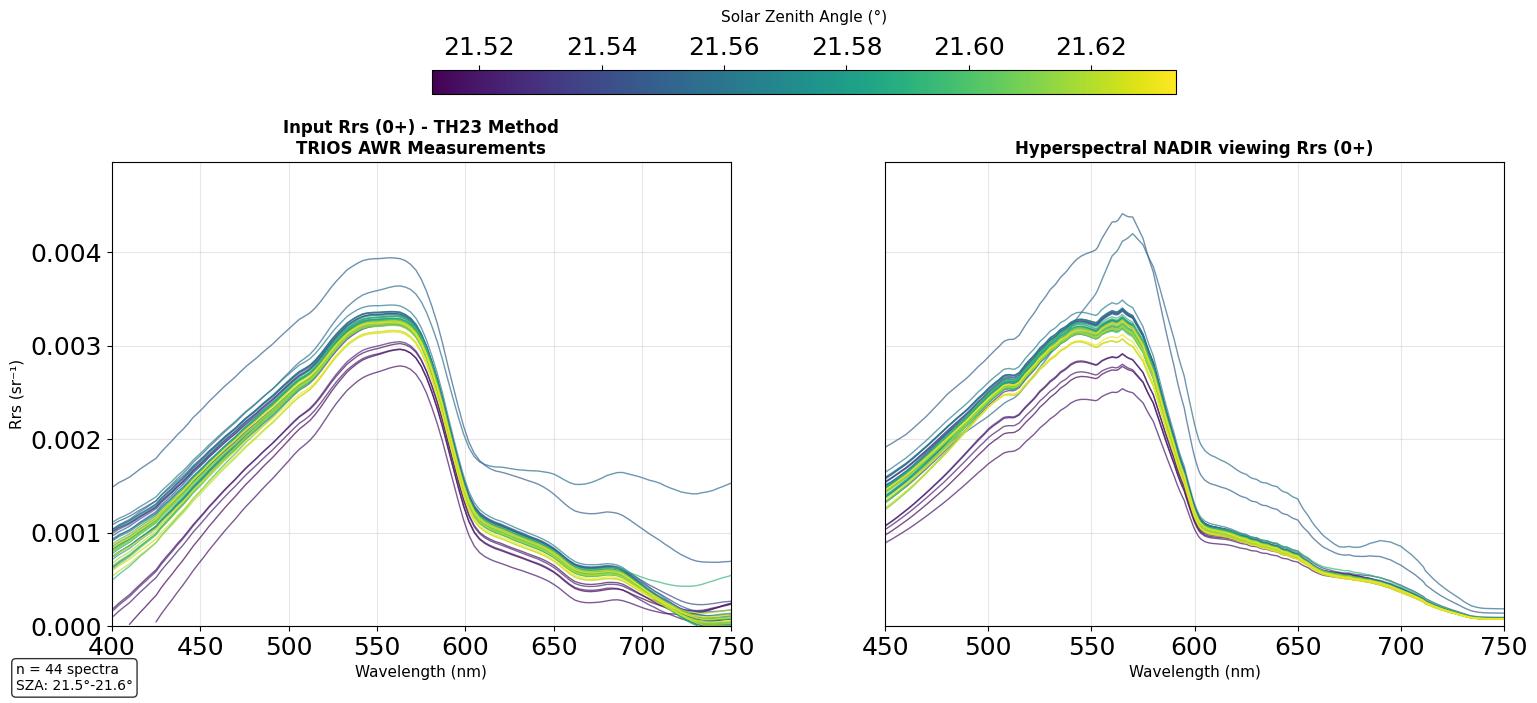

Spectral comparison completed!
Left panel: 44 input spectra (measured, actual wavelengths)
Right panel: 44 forward model spectra (simulated, 1nm resolution)
Left wavelength range: 400-750 nm (actual measurements)
Right wavelength range: 450-750 nm (1nm intervals)
Solar zenith angles: 21.5°-21.6°


In [22]:
# Simple side-by-side spectral comparison with different wavelength resolutions
import matplotlib.cm as cm

print("Creating side-by-side spectral comparison...")
print(f"Using {len(simulated_spectra)} spectra from forward simulation")

# Create side-by-side comparison plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# Create colormap for solar zenith angles
sza_values_array = np.array(sza_values[:len(simulated_spectra)])
norm = plt.Normalize(vmin=sza_values_array.min(), vmax=sza_values_array.max())
cmap = cm.viridis

# Left panel: Input Rrs (0+) - Measured data with actual wavelengths (400-750 nm)
ax1.set_title('Input Rrs (0+) - TH23 Method\nTRIOS AWR Measurements', fontsize=12, fontweight='bold')
for i, spectrum_data in enumerate(simulated_spectra):
    wl = spectrum_data['wavelength']  # Actual wavelengths from measurements
    rrs_measured = spectrum_data['rrs_measured']
    sza = sza_values_array[i]
    color = cmap(norm(sza))
    ax1.plot(wl, rrs_measured, '-', color=color, alpha=0.7, linewidth=1)

ax1.set_xlabel('Wavelength (nm)', fontsize=11)
ax1.set_ylabel('Rrs (sr⁻¹)', fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(400, 750)

# Right panel: Forward model Rrs (0+) - High resolution simulation (450-750 nm, 1nm interval)
ax2.set_title('Hyperspectral NADIR viewing Rrs (0+)', fontsize=12, fontweight='bold')

# Create high-resolution wavelength grid
wl_hires = np.arange(450, 751, 1)  # 450-750 nm with 1nm interval

# Forward simulate each spectrum at high resolution
for i, spectrum_data in enumerate(simulated_spectra):
    try:
        # Get SABER parameters for this spectrum
        params = spectrum_data['params']
        sza = sza_values_array[i]
        
        # Create parameter vector for SABER with names
        par_vec = ro.FloatVector([
            params['chl'],           # aphy_440
            params['a_g_440'],       # aCDOM_440  
            params['bb_p_550'],      # aNAP_440
            params['a_g_s'],         # bbphy_550
            params['bb_p_gamma']     # bbNAP_550 / Sf
        ])
        par_vec.names = ro.StrVector(['chl', 'a_g_440', 'bb_p_550', 'a_g_s', 'bb_p_gamma'])
        
        # Calculate IOPs at high resolution
        iops_hires = saber.iop_from_oac(
            wavelength=ro.FloatVector(wl_hires),
            par=par_vec
        )
        
        # Forward simulate at high resolution
        rrs_sim_0m_hires = saber.forward_am03(
            wavelength=ro.FloatVector(wl_hires),
            iop=iops_hires,
            water_type=2,
            theta_sun=float(sza),
            theta_view=0,
            h_w=ro.NULL,
            r_b=ro.NULL
        )
        
        # Convert to surface (0+)
        rrs_sim_hires = saber.rrs_0m_to_0p(rrs_sim_0m_hires)
        
        # Plot high-resolution simulation
        color = cmap(norm(sza))
        ax2.plot(wl_hires, np.array(rrs_sim_hires), '-', color=color, alpha=0.7, linewidth=1)
        
    except Exception as e:
        print(f"  Failed high-res simulation for spectrum {i+1}: {str(e)}")
        continue

ax2.set_xlabel('Wavelength (nm)', fontsize=11)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(450, 750)

# Set shared Y-axis range covering both plots and hide right Y-axis
# Get Y-axis limits from both plots
y_min_left = min([min(spectrum_data['rrs_measured']) for spectrum_data in simulated_spectra])
y_max_left = max([max(spectrum_data['rrs_measured']) for spectrum_data in simulated_spectra])

# Get approximate range from right plot (using a sample simulation)
y_min_right = 0  # Approximate minimum for forward simulations
y_max_right = y_max_left * 1.2  # Approximate maximum, usually similar or slightly higher

# Set common Y-axis range with some padding
y_min_common = min(y_min_left, y_min_right) * 0.95
y_max_common = max(y_max_left, y_max_right) * 1.05

ax1.set_ylim(y_min_common, y_max_common)
ax2.set_ylim(y_min_common, y_max_common)

# Hide right Y-axis labels and ticks
ax2.set_ylabel('')
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# Create custom positioned colorbar at X=700, Y=0.004
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

# Create horizontal colorbar at the top of the figure
cbar = fig.colorbar(sm, ax=[ax1, ax2], orientation='horizontal', 
                   location='top', pad=0.20, shrink=0.6, aspect=30)
cbar.set_label('Solar Zenith Angle (°)', fontsize=11, labelpad=10)

# Add statistics text
n_spectra = len(simulated_spectra)
sza_range_text = f'n = {n_spectra} spectra\nSZA: {sza_values_array.min():.1f}°-{sza_values_array.max():.1f}°'
fig.text(0.02, 0.02, sza_range_text, fontsize=10, 
         bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

# Adjust layout to make even more space for the colorbar at the top (additional 15%)
plt.subplots_adjust(top=0.68, bottom=0.1, left=0.08, right=0.95, wspace=0.25)
plt.show()

print("="*50)
print("Spectral comparison completed!")
print(f"Left panel: {n_spectra} input spectra (measured, actual wavelengths)")
print(f"Right panel: {n_spectra} forward model spectra (simulated, 1nm resolution)")
print(f"Left wavelength range: 400-750 nm (actual measurements)")
print(f"Right wavelength range: 450-750 nm (1nm intervals)")
print(f"Solar zenith angles: {sza_values_array.min():.1f}°-{sza_values_array.max():.1f}°")